# Relative Representations for Cognitive Graphs

### SETUP

In [1]:
!pip install igraph
!pip install cairocffi
!pip install numba
!pip install inferactively-pymdp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 35.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.9/86.9 kB 3.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for cairocffi: filename=cairocffi-1.5.1-py3-none-any.whl size=90523 sha256=9c098cec2ac3789b02f1dca169f42d473825240bf14a35690b86b2c54f6d0482
  Stored in directory: /root/.cache/pip/wheels/3d/f0/15/e20ff54ef59ec58a08e230bd3874e6f412b09e6a3093f856a7
Successfully built cairocffi
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/col

In [2]:
import os
import sys
import torch
import numpy as np
import numba as nb
import igraph
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from tqdm import trange
from pymdp import maths, utils, control
from matplotlib import cm, colors
from sklearn.decomposition import PCA
from scipy.special import softmax

In [3]:
#Pretty colors for plots
custom_colors = (
    np.array(
        [
            [214, 214, 214],
            [85, 35, 157],
            [253, 252, 144],
            [114, 245, 144],
            [151, 38, 20],
            [239, 142, 192],
            [214, 134, 48],
            [140, 194, 250],
            [72, 160, 162],
        ]
    )
    / 256
)
if not os.path.exists("figures"):
    os.makedirs("figures")
if not os.path.exists("data"):
    os.makedirs("data")


### Code (slightly modified) from [chmm_actions.py](https://github.com/vicariousinc/naturecomm_cscg/blob/main/chmm_actions.py) ###

In [4]:
def validate_seq(x, a, n_clones=None):
    """Validate an input sequence of observations x and actions a"""
    assert len(x) == len(a) > 0
    assert len(x.shape) == len(a.shape) == 1, "Flatten your array first"
    assert x.dtype == a.dtype == np.int64
    assert 0 <= x.min(), "Number of emissions inconsistent with training sequence"
    if n_clones is not None:
        assert len(n_clones.shape) == 1, "Flatten your array first"
        assert n_clones.dtype == np.int64
        assert all(
            [c > 0 for c in n_clones]
        ), "You can't provide zero clones for any emission"
        n_emissions = n_clones.shape[0]
        assert (
            x.max() < n_emissions
        ), "Number of emissions inconsistent with training sequence"


# Generate an (action, observation, ground-truth location) sequence given a room encoded as a grid of observations
# (And optionally, a pre-specified action sequence)
def datagen_structured_obs_room(
    room,
    start_r=None,
    start_c=None,
    no_left=[],
    no_right=[],
    no_up=[],
    no_down=[],
    length=10000,
    actions=None,
    seed=42,
):
    """room is a 2d numpy array. inaccessible locations are marked by -1.
    start_r, start_c: starting locations

    In addition, there are invisible obstructions in the room
    which disallows certain actions from certain states.

    no_left:
    no_right:
    no_up:
    no_down:

    Each of the above are list of states from which the corresponding action is not allowed.

    """
    if seed is not None:
        np.random.seed(seed)
    H, W = room.shape
    if start_r is None or start_c is None:
        start_r, start_c = np.random.randint(H), np.random.randint(W)

    if actions is not None:
        if length is not None:
            print("Warning: both `length` and `actions` params were supplied. Using length of action sequence.")
        length = len(actions)
    actions_taken = np.zeros(length, int)
    x = np.zeros(length, int)  # observations
    rc = np.zeros((length, 2), int)  # actual r&c

    r, c = start_r, start_c
    x[0] = room[r, c]
    rc[0] = r, c

    count = 0
    while count < length - 1:

        if actions is None:

            act_list = [0, 1, 2, 3]  # 0: left, 1: right, 2: up, 3: down
            if (r, c) in no_left:
                act_list.remove(0)
            if (r, c) in no_right:
                act_list.remove(1)
            if (r, c) in no_up:
                act_list.remove(2)
            if (r, c) in no_down:
                act_list.remove(3)

            a = np.random.choice(act_list)
        else:
            a = actions[count]

        # Check for actions taking out of the matrix boundary.
        prev_r = r
        prev_c = c
        if a == 0 and 0 < c:
            c -= 1
        elif a == 1 and c < W - 1:
            c += 1
        elif a == 2 and 0 < r:
            r -= 1
        elif a == 3 and r < H - 1:
            r += 1

        # Check whether action is taking to inaccessible states.
        temp_x = room[r, c]
        if temp_x == -1:
            r = prev_r
            c = prev_c
            pass

        actions_taken[count] = a            
        x[count + 1] = room[r, c]
        rc[count + 1] = r, c
        count += 1

    return actions_taken, x, rc


#### Functions to support main CSCG class

In [5]:
@nb.njit # Not sure if this is actually necessary/useful
def compute_p_obs(message, MAP=False):
    p_obs = message.max() if MAP else message.sum()
    assert p_obs > 0
    return p_obs, message / p_obs


# @nb.njit
# def bw_forward(T_tr, Pi, n_clones, x, a, store_messages=False):
#     """Log-probability of a sequence, using full likelihood (takes 'soft' observations))"""

#     dtype = T_tr.dtype.type

#     log2_lik = np.zeroS(len(x), dtype)

#     # forward pass
#     i = x[0]
#     message = Pi.dot()


@nb.njit
def forward(T_tr, Pi, n_clones, x, a, store_messages=False):
    """Log-probability of a sequence, and optionally, messages"""
    ### 
    # `T_tr`: transition matrix with last 2 dims transposed - [action, to_state, from_state] 
    # `Pi`: Iniital state distribution
    # `n_clones`: vector of number of clones per possible observation
    # `x`: sequence of observations
    # `a`: sequence of actions/control states

    # Constructs a list of hidden state indices at which each clone group starts
    state_loc = np.hstack((np.array([0], dtype=n_clones.dtype), n_clones)).cumsum()
    dtype = T_tr.dtype.type

    # Init log likelihood
    log2_lik = np.zeros(len(x), dtype)

    # forward pass

    # first timestep: use prior
    i = x[0]
    i_start, i_stop = state_loc[i:i + 2] 
    message = Pi[i_start:i_stop].copy().astype(dtype) # Leverage the fact that p(O|S) is 0 if S isn't in O's clones
    p_obs = message.sum() # Marginalize just over clones of observation - initial probs are p(clones)
    assert p_obs > 0
    message /= p_obs # Re-normalize message: p(obs|clones) = 1
    log2_lik[0] = np.log2(p_obs)
    if store_messages:
        mess_loc = np.hstack(
            (np.array([0], dtype=n_clones.dtype), n_clones[x])
        ).cumsum()
        mess_fwd = np.empty(mess_loc[-1], dtype=dtype)
        t_start, t_stop = mess_loc[:2]
        mess_fwd[t_start:t_stop] = message
    else:
        mess_fwd = None
    # Recursively compute probs for subsequent timesteps using transition matrix
    for t in range(1, x.shape[0]):
        aij, i, j = (
            a[t - 1],
            x[t - 1],
            x[t],
        )  # at time t-1 -> t we go from observation i to observation j
        (i_start, i_stop), (j_start, j_stop) = (
            state_loc[i : i + 2],
            state_loc[j : j + 2],
        )
                  # (n_clones[j], n_clones[i]) * n_clones[i] = n_clones[j]
                  # = p(Z_{n+1}|Z_n)
        message = np.ascontiguousarray(T_tr[aij, j_start:j_stop, i_start:i_stop]).dot(
            message
        )
        p_obs = message.sum()
        assert p_obs > 0
        message /= p_obs
        log2_lik[t] = np.log2(p_obs)
        if store_messages:
            t_start, t_stop = mess_loc[t : t + 2]
            mess_fwd[t_start:t_stop] = message
    return log2_lik, mess_fwd


def forwardE(T_tr, E, Pi, n_clones, x, a, store_messages=False):
    """Log-probability of a sequence, and optionally, messages"""
    # `E`: 'Emission probabilities' (likelihood matrix)
    assert (n_clones.sum(), len(n_clones)) == E.shape
    dtype = T_tr.dtype.type

    # forward pass
    t, log2_lik = 0, np.zeros(len(x), dtype)
    j = x[t]
    message = Pi * E[:, j]
    p_obs, message = compute_p_obs(message)
    log2_lik[0] = np.log2(p_obs)
    if store_messages:
        mess_fwd = np.empty((len(x), E.shape[0]), dtype=dtype)
        mess_fwd[t] = message
    for t in range(1, x.shape[0]):
        aij, j = (
            a[t - 1],
            x[t],
        )  # at time t-1 -> t we go from observation i to observation j

        # print("pre-Msg", message, message.shape)
        # print("Ttr", T_tr[aij], T_tr[aij].shape)
        # plt.matshow(T_tr[aij])
        message = T_tr[aij].dot(message)
        # print("pre-E msg", message, message.shape)
        message *= E[:, j]
        # print("post_E multi", message)
        # import time
        # time.sleep(2)

        p_obs, message = compute_p_obs(message)
        log2_lik[t] = np.log2(p_obs)
        if store_messages:
            mess_fwd[t] = message
    if store_messages:
        return log2_lik, mess_fwd
    else:
        return log2_lik


@nb.njit
def forward_mp(T_tr, Pi, n_clones, x, a, store_messages=False):
    """Log-probability of a sequence, and optionally, messages"""
    ### Version of forward pass used for max-product message passing / MAP inference of latents
    # The difference to `forward` is just that rather than marginalizing over clones to get p(obs) we 
    # take the max likelihood clone
    state_loc = np.hstack((np.array([0], dtype=n_clones.dtype), n_clones)).cumsum()
    dtype = T_tr.dtype.type

    # forward pass
    t, log2_lik = 0, np.zeros(len(x), dtype)
    j = x[t]
    j_start, j_stop = state_loc[j : j + 2]
    message = Pi[j_start:j_stop].copy().astype(dtype)

    p_obs = message.max()
    assert p_obs > 0
    message /= p_obs
    log2_lik[0] = np.log2(p_obs)
    if store_messages:
        mess_loc = np.hstack(
            (np.array([0], dtype=n_clones.dtype), n_clones[x])
        ).cumsum()
        mess_fwd = np.empty(mess_loc[-1], dtype=dtype)
        t_start, t_stop = mess_loc[t : t + 2]
        mess_fwd[t_start:t_stop] = message
    else:
        mess_fwd = None

    for t in range(1, x.shape[0]):
        aij, i, j = (
            a[t - 1],
            x[t - 1],
            x[t],
        )  # at time t-1 -> t we go from observation i to observation j
        (i_start, i_stop), (j_start, j_stop) = (
            state_loc[i : i + 2],
            state_loc[j : j + 2],
        )
        new_message = np.zeros(j_stop - j_start, dtype=dtype)
        for d in range(len(new_message)):
            new_message[d] = (T_tr[aij, j_start + d, i_start:i_stop] * message).max()        
        message = new_message
        p_obs = message.max()
        assert p_obs > 0
        message /= p_obs
        log2_lik[t] = np.log2(p_obs)
        if store_messages:
            t_start, t_stop = mess_loc[t : t + 2]
            mess_fwd[t_start:t_stop] = message
    return log2_lik, mess_fwd
  

def forwardE_mp(T_tr, E, Pi, n_clones, x, a, store_messages=False):
    """Log-probability of a sequence, and optionally, messages"""
    assert (n_clones.sum(), len(n_clones)) == E.shape
    dtype = T_tr.dtype.type

    # forward pass
    t, log2_lik = 0, np.zeros(len(x), dtype)
    j = x[t]
    message = Pi * E[:, j]
    p_obs, message = compute_p_obs(message, MAP=True)

    # p_obs = message.max()
    # assert p_obs > 0
    # message /= p_obs
    log2_lik[0] = np.log2(p_obs)
    if store_messages:
        mess_fwd = np.empty((len(x), E.shape[0]), dtype=dtype)
        mess_fwd[t] = message
    for t in range(1, x.shape[0]):
        aij, j = (
            a[t - 1],
            x[t],
        )  # at time t-1 -> t we go from observation i to observation j
        message = (T_tr[aij] * message.reshape(1, -1)).max(1)
        message *= E[:, j]
        p_obs, message = compute_p_obs(message, MAP=True)
        # p_obs = message.max()
        # assert p_obs > 0
        # message /= p_obs
        log2_lik[t] = np.log2(p_obs)
        if store_messages:
            mess_fwd[t] = message
    if store_messages:
        return log2_lik, mess_fwd
    else:
        return log2_lik


def forward_mp_all(T_tr, Pi_x, Pi_a, n_clones, target_state, max_steps):
    """Log-probability of a sequence, and optionally, messages"""
    # Compute likelihood using all hidden states, not just clones of observation
    # forward pass
    t, log2_lik = 0, []
    message = Pi_x
    p_obs, message = compute_p_obs(message, MAP=True)
    # p_obs = message.max()
    # assert p_obs > 0
    # message /= p_obs
    log2_lik.append(np.log2(p_obs))
    mess_fwd = []
    mess_fwd.append(message)
    T_tr_maxa = (T_tr * Pi_a.reshape(-1, 1, 1)).max(0)
    for t in range(1, max_steps):
        message = (T_tr_maxa * message.reshape(1, -1)).max(1)
        p_obs, message = compute_p_obs(message, MAP=True)
        # p_obs = message.max()
        # assert p_obs > 0
        # message /= p_obs
        log2_lik.append(np.log2(p_obs))
        mess_fwd.append(message)
        if message[target_state] > 0:
            break
    else:
        assert False, "Unable to find a bridging path"
    return np.array(log2_lik), np.array(mess_fwd)


##### Backward message passing / state inference

In [6]:
@nb.njit
def rargmax(x):
    # return x.argmax()  # <- favors clustering towards smaller state numbers
    return np.random.choice((x == x.max()).nonzero()[0])


@nb.njit
def backtrace(T, n_clones, x, a, mess_fwd):
    """Compute backward messages."""
    state_loc = np.hstack((np.array([0], dtype=n_clones.dtype), n_clones)).cumsum()
    mess_loc = np.hstack((np.array([0], dtype=n_clones.dtype), n_clones[x])).cumsum()
    code = np.zeros(x.shape[0], dtype=np.int64)

    # backward pass
    t = x.shape[0] - 1
    i = x[t]
    t_start, t_stop = mess_loc[t : t + 2]
    belief = mess_fwd[t_start:t_stop]
    code[t] = rargmax(belief)
    for t in range(x.shape[0] - 2, -1, -1):
        aij, i, j = (
            a[t],
            x[t],
            x[t + 1],
        )  # at time t -> t+1 we go from observation i to observation j
        (i_start, i_stop), j_start = state_loc[i : i + 2], state_loc[j]
        t_start, t_stop = mess_loc[t : t + 2]
        belief = (
            mess_fwd[t_start:t_stop] * T[aij, i_start:i_stop, j_start + code[t + 1]]
        )
        code[t] = rargmax(belief)
    states = state_loc[x] + code
    return states
    

def backwardE(T, E, n_clones, x, a):
    """Compute backward messages."""
    assert (n_clones.sum(), len(n_clones)) == E.shape
    dtype = T.dtype.type

    # backward pass
    t = x.shape[0] - 1
    message = np.ones(E.shape[0], dtype)
    message /= message.sum()
    mess_bwd = np.empty((len(x), E.shape[0]), dtype=dtype)
    mess_bwd[t] = message
    for t in range(x.shape[0] - 2, -1, -1):
        aij, j = (
            a[t],
            x[t + 1],
        )  # at time t -> t+1 we go from observation i to observation j
        message = T[aij].dot(message * E[:, j])
        p_obs, message = compute_p_obs(message)
        # p_obs = message.sum()
        # assert p_obs > 0
        # message /= p_obs
        mess_bwd[t] = message
    return mess_bwd


def backtraceE(T, E, n_clones, x, a, mess_fwd):
    """Compute backward messages."""
    assert (n_clones.sum(), len(n_clones)) == E.shape
    states = np.zeros(x.shape[0], dtype=np.int64)

    # backward pass
    t = x.shape[0] - 1
    belief = mess_fwd[t]
    states[t] = rargmax(belief)
    for t in range(x.shape[0] - 2, -1, -1):
        aij = a[t]  # at time t -> t+1 we go from observation i to observation j
        belief = mess_fwd[t] * T[aij, :, states[t + 1]]
        states[t] = rargmax(belief)
    return states


@nb.njit
def backward(T, n_clones, x, a):
    """Compute backward messages."""
    state_loc = np.hstack((np.array([0], dtype=n_clones.dtype), n_clones)).cumsum()
    dtype = T.dtype.type

    # backward pass
    t = x.shape[0] - 1
    i = x[t]
    message = np.ones(n_clones[i], dtype) / n_clones[i]
    message /= message.sum()
    mess_loc = np.hstack((np.array([0], dtype=n_clones.dtype), n_clones[x])).cumsum()
    mess_bwd = np.empty(mess_loc[-1], dtype)
    t_start, t_stop = mess_loc[t : t + 2]
    mess_bwd[t_start:t_stop] = message
    for t in range(x.shape[0] - 2, -1, -1):
        aij, i, j = (
            a[t],
            x[t],
            x[t + 1],
        )  # at time t -> t+1 we go from observation i to observation j
        (i_start, i_stop), (j_start, j_stop) = (
            state_loc[i : i + 2],
            state_loc[j : j + 2],
        )
        message = np.ascontiguousarray(T[aij, i_start:i_stop, j_start:j_stop]).dot(
            message
        )
        p_obs, message = compute_p_obs(message)
        # p_obs = message.sum()
        # assert p_obs > 0
        # message /= p_obs
        t_start, t_stop = mess_loc[t : t + 2]
        mess_bwd[t_start:t_stop] = message
    return mess_bwd


def backtrace_all(T, Pi_a, n_clones, mess_fwd, target_state):
    """Compute backward messages."""
    states = np.zeros(mess_fwd.shape[0], dtype=np.int64)
    actions = np.zeros(mess_fwd.shape[0], dtype=np.int64)
    n_states = T.shape[1]
    # backward pass
    t = mess_fwd.shape[0] - 1
    actions[t], states[t] = (
        -1,
        target_state,
    )  # last actions is irrelevant, use an invalid value
    for t in range(mess_fwd.shape[0] - 2, -1, -1):
        belief = (
            mess_fwd[t].reshape(1, -1) * T[:, :, states[t + 1]] * Pi_a.reshape(-1, 1)
        )
        a_s = rargmax(belief.flatten())
        actions[t], states[t] = a_s // n_states, a_s % n_states
    return actions, states


##### Update transition matrix

In [7]:
@nb.njit
def updateC(C, T, n_clones, mess_fwd, mess_bwd, x, a):
    # Reset / update pseudocounts matrix
    state_loc = np.hstack((np.array([0], dtype=n_clones.dtype), n_clones)).cumsum()
    mess_loc = np.hstack((np.array([0], dtype=n_clones.dtype), n_clones[x])).cumsum()
    timesteps = len(x)
    C[:] = 0
    for t in range(1, timesteps):
        aij, i, j = (
            a[t - 1],
            x[t - 1],
            x[t],
        )  # at time t-1 -> t we go from observation i to observation j
        (tm1_start, tm1_stop), (t_start, t_stop) = (
            mess_loc[t - 1 : t + 1],
            mess_loc[t : t + 2],
        )
        (i_start, i_stop), (j_start, j_stop) = (
            state_loc[i : i + 2],
            state_loc[j : j + 2],
        )
        # Compute unnormalized variational density(?) as product of transition matrix, forward and backward messages
        q = (
            mess_fwd[tm1_start:tm1_stop].reshape(-1, 1)
            * T[aij, i_start:i_stop, j_start:j_stop]
            * mess_bwd[t_start:t_stop].reshape(1, -1)
        )
        q /= q.sum()
        # Treating probabilities over hidden states as "soft" aggregated states for pseudocount update
        C[aij, i_start:i_stop, j_start:j_stop] += q
        

def updateCE(CE, E, n_clones, mess_fwd, mess_bwd, x, a):
    timesteps = len(x)
    gamma = mess_fwd * mess_bwd
    norm = gamma.sum(1, keepdims=True)
    norm[norm == 0] = 1
    gamma /= norm
    CE[:] = 0
    for t in range(timesteps):
        CE[:, x[t]] += gamma[t]


#### Main CHMM (CSCG) class

In [8]:
def plot_graph(
    chmm, x, a, output_file, cmap=cm.Spectral, multiple_episodes=False, vertex_size=30, n_clones=70
):
    states = chmm.decode(x, a)[1]
  
    v = np.unique(states)
    if multiple_episodes:
        T = chmm.C[:, v][:, :, v][:-1, 1:, 1:]
        v = v[1:]
    else:
        T = chmm.C[:, v][:, :, v]
    A = T.sum(0)
    A /= A.sum(1, keepdims=True)

    g = igraph.Graph.Adjacency((A > 0).tolist())
    node_labels = np.arange(x.max() + 1).repeat(n_clones)[v]
    if multiple_episodes:
        node_labels -= 1
    colors = [cmap(nl)[:3] for nl in node_labels / node_labels.max()]
    out = igraph.plot(
        g,
        output_file,
        layout=g.layout("kamada_kawai"),
        vertex_color=colors,
        vertex_label=v,
        vertex_size=vertex_size,
        margin=50,
    )

    return out


def get_mess_fwd(chmm, x, a=None, pseudocount=0.0, pseudocount_E=0.0):
    n_clones = chmm.n_clones
    E = np.zeros((n_clones.sum(), len(n_clones)))
    last = 0
    for c in range(len(n_clones)):
        E[last : last + n_clones[c], c] = 1
        last += n_clones[c]
    E += pseudocount_E
    norm = E.sum(1, keepdims=True)
    norm[norm == 0] = 1
    E /= norm
    T = chmm.C + pseudocount
    norm = T.sum(2, keepdims=True)
    norm[norm == 0] = 1
    T /= norm
    if a is None:
        T = T.mean(0, keepdims=True)
        a = x * 0
    log2_lik, mess_fwd = forwardE(
        T.transpose(0, 2, 1), E, chmm.Pi_x, chmm.n_clones, x, a, store_messages=True
    )
    return mess_fwd


def place_field(mess_fwd, rc, clone):
    assert mess_fwd.shape[0] == rc.shape[0] and clone < mess_fwd.shape[1]
    field = np.zeros(rc.max(0) + 1)
    count = np.zeros(rc.max(0) + 1, int)
    for t in range(mess_fwd.shape[0]):
        r, c = rc[t]
        field[r, c] += mess_fwd[t, clone]
        count[r, c] += 1
    count[count == 0] = 1
    return field / count


In [9]:
class CHMM(object):
    def __init__(self, n_clones, x, a, pseudocount=0.0, dtype=np.float32, seed=42):
        """Construct a CHMM objct. n_clones is an array where n_clones[i] is the
        number of clones assigned to observation i. x and a are the observation sequences
        and action sequences, respectively."""
        # pseudocount: smoothing factor
        if seed is not None:
            np.random.seed(seed)
        self.n_clones = n_clones
        self.state_loc = np.hstack((np.array([0], dtype=n_clones.dtype), n_clones)).cumsum()
        validate_seq(x, a, self.n_clones)
        assert pseudocount >= 0.0, "The pseudocount should be positive"
        print("Average number of clones:", n_clones.mean())
        self.pseudocount = pseudocount
        self.dtype = dtype
        n_states = self.n_clones.sum()
        n_actions = a.max() + 1

        # Random init of counts matrix (for updating transition probs)
        self.C = np.random.rand(n_actions, n_states, n_states).astype(dtype)
        
        # Flat distributions over states and actions
        self.Pi_x = np.ones(n_states) / n_states
        self.Pi_a = np.ones(n_actions) / n_actions

        # Create initial transition matrix (by normalizing random counts)
        self.update_T()

    def update_T(self):
        """Update the transition matrix given the accumulated counts matrix."""
        self.T = self.C + self.pseudocount
        norm = self.T.sum(2, keepdims=True)
        norm[norm == 0] = 1 # Not sure I get this
        self.T /= norm

    # def update_T(self):
    #     self.T = self.C + self.pseudocount
    #     norm = self.T.sum(2, keepdims=True)  # old model (conditional on actions)
    #     norm[norm == 0] = 1
    #     self.T /= norm
    #     norm = self.T.sum((0, 2), keepdims=True)  # new model (generates actions too)
    #     norm[norm == 0] = 1
    #     self.T /= norm

    def update_E(self, CE):
        """Update the emission matrix.""" # Likelihood
        E = CE + self.pseudocount
        norm = E.sum(1, keepdims=True)
        norm[norm == 0] = 1
        E /= norm
        return E

    def bps(self, x, a):
        """Compute the log likelihood (log base 2) of a sequence of observations and actions."""
        validate_seq(x, a, self.n_clones)
        log2_lik = forward(self.T.transpose(0, 2, 1), self.Pi_x, self.n_clones, x, a)[0]
        return -log2_lik

    def bpsE(self, E, x, a):
        """Compute the log likelihood using an alternate emission matrix."""
        validate_seq(x, a, self.n_clones)
        log2_lik = forwardE(
            self.T.transpose(0, 2, 1), E, self.Pi_x, self.n_clones, x, a
        )
        return -log2_lik

    def bpsV(self, x, a):
        ## What is this?
        validate_seq(x, a, self.n_clones)
        log2_lik = forward_mp(
            self.T.transpose(0, 2, 1), self.Pi_x, self.n_clones, x, a
        )[0]
        return -log2_lik

    def decode(self, x, a):
        """Compute the MAP assignment of latent variables using max-product message passing."""
        log2_lik, mess_fwd = forward_mp(
            self.T.transpose(0, 2, 1),
            self.Pi_x,
            self.n_clones,
            x,
            a,
            store_messages=True,
        )
        states = backtrace(self.T, self.n_clones, x, a, mess_fwd)
        return -log2_lik, states

    def decodeE(self, E, x, a):
        """Compute the MAP assignment of latent variables using max-product message passing
        with an alternative emission matrix."""
        log2_lik, mess_fwd = forwardE_mp(
            self.T.transpose(0, 2, 1),
            E,
            self.Pi_x,
            self.n_clones,
            x,
            a,
            store_messages=True,
        )
        states = backtraceE(self.T, E, self.n_clones, x, a, mess_fwd)
        return -log2_lik, states

    def learn_em_T(self, x, a, n_iter=100, term_early=True, save_every=None):
        """Run EM training, keeping E deterministic and fixed, learning T"""
        sys.stdout.flush()
        convergence = []
        pbar = trange(n_iter, position=0)
        log2_lik_old = -np.inf
        for it in pbar:
            # E

            # Forward pass: entire [observation, action] sequence at once
            # 
            log2_lik, mess_fwd = forward(
                self.T.transpose(0, 2, 1),
                self.Pi_x,
                self.n_clones,
                x,
                a,
                store_messages=True,
            )
            mess_bwd = backward(self.T, self.n_clones, x, a)
            # Update pseudocounts, using transition matrix, forward and backward messages and sequence
            updateC(self.C, self.T, self.n_clones, mess_fwd, mess_bwd, x, a)
            # M
            self.update_T() # Not much to this 'M step': use the already-computed counts and normalize
            convergence.append(-log2_lik.mean())
            pbar.set_postfix(train_bps=convergence[-1])
            if log2_lik.mean() <= log2_lik_old:
                if term_early:
                    break
            log2_lik_old = log2_lik.mean()

            if save_every is not None and it % save_every == 0:
                np.save("data/transitions2", self.T)
        return convergence

    def learn_viterbi_T(self, x, a, n_iter=100, save_every=None):
        """Run Viterbi training, keeping E deterministic and fixed, learning T"""
        sys.stdout.flush()
        convergence = []
        pbar = trange(n_iter, position=0)
        log2_lik_old = -np.inf
        for it in pbar:
            # E - (Diff from EM: `forawrd_mp`; uses max prob instead of marginalizing)
            log2_lik, mess_fwd = forward_mp(
                self.T.transpose(0, 2, 1),
                self.Pi_x,
                self.n_clones,
                x,
                a,
                store_messages=True,
            )
            # `backtrace` also different from EM
            # This returns a maximum a posteriori estimate of the hidden sequence, given obs sequence
            states = backtrace(self.T, self.n_clones, x, a, mess_fwd) 
            # Update count/transition matrices to make inferred hidden sequence more likely
            # (What is this doing? )
            self.C[:] = 0
            for t in range(1, len(x)):
                aij, i, j = (
                    a[t - 1],
                    states[t - 1],
                    states[t],
                )  # at time t-1 -> t we go from observation i to observation j
                self.C[aij, i, j] += 1.0
            # M
            self.update_T()
            convergence.append(-log2_lik.mean())
            pbar.set_postfix(train_bps=convergence[-1])
            if log2_lik.mean() <= log2_lik_old:
                pass #break
            log2_lik_old = log2_lik.mean()

            if save_every is not None and it % save_every == 0:
                np.save("data/transitions", self.T)
        return convergence

    def learn_em_E(self, x, a, n_iter=100, pseudocount_extra=1e-20):
        """Run Viterbi training, keeping T fixed, learning E"""
        sys.stdout.flush()
        n_emissions, n_states = len(self.n_clones), self.n_clones.sum()
        CE = np.ones((n_states, n_emissions), self.dtype)
        E = self.update_E(CE + pseudocount_extra)
        convergence = []
        pbar = trange(n_iter, position=0)
        log2_lik_old = -np.inf
        for it in pbar:
            # E
            log2_lik, mess_fwd = forwardE(
                self.T.transpose(0, 2, 1),
                E,
                self.Pi_x,
                self.n_clones,
                x,
                a,
                store_messages=True,
            )
            mess_bwd = backwardE(self.T, E, self.n_clones, x, a)
            updateCE(CE, E, self.n_clones, mess_fwd, mess_bwd, x, a)
            # M
            E = self.update_E(CE + pseudocount_extra)
            convergence.append(-log2_lik.mean())
            pbar.set_postfix(train_bps=convergence[-1])
            if log2_lik.mean() <= log2_lik_old:
                break
            log2_lik_old = log2_lik.mean()
        return convergence, E

    def sample(self, length):
        """Sample from the CHMM."""
        assert length > 0
        state_loc = np.hstack(([0], self.n_clones)).cumsum(0)
        sample_x = np.zeros(length, dtype=np.int64)
        sample_a = np.random.choice(len(self.Pi_a), size=length, p=self.Pi_a)

        # Sample
        p_h = self.Pi_x
        for t in range(length):
            h = np.random.choice(len(p_h), p=p_h)
            sample_x[t] = np.digitize(h, state_loc) - 1
            p_h = self.T[sample_a[t], h]
        return sample_x, sample_a

    def sample_sym(self, sym, length):
        """Sample from the CHMM conditioning on an inital observation."""
        # Prepare structures
        assert length > 0
        state_loc = np.hstack(([0], self.n_clones)).cumsum(0)

        seq = [sym]

        alpha = np.ones(self.n_clones[sym])
        alpha /= alpha.sum()

        for _ in range(length):
            obs_tm1 = seq[-1]
            T_weighted = self.T.sum(0)

            long_alpha = np.dot(
                alpha, T_weighted[state_loc[obs_tm1] : state_loc[obs_tm1 + 1], :]
            )
            long_alpha /= long_alpha.sum()
            idx = np.random.choice(np.arange(self.n_clones.sum()), p=long_alpha)

            sym = np.digitize(idx, state_loc) - 1
            seq.append(sym)

            temp_alpha = long_alpha[state_loc[sym] : state_loc[sym + 1]]
            temp_alpha /= temp_alpha.sum()
            alpha = temp_alpha

        return seq

    def bridge(self, state1, state2, max_steps=100):
        Pi_x = np.zeros(self.n_clones.sum(), dtype=self.dtype)
        Pi_x[state1] = 1
        log2_lik, mess_fwd = forward_mp_all(
            self.T.transpose(0, 2, 1), Pi_x, self.Pi_a, self.n_clones, state2, max_steps
        )
        s_a = backtrace_all(self.T, self.Pi_a, self.n_clones, mess_fwd, state2)
        return s_a

In [10]:
def stable_normalize(matrix, eps=1e-14):
    return utils.norm_dist(matrix + eps)

def get_joint_posterior_from_marginals(posterior_marginals):
  """ Function that computes joint by product of marginals. Can also just use `maths.spm_cross` but wrote this here to be transparent with what we spoke about in the thread w/ @AlexK
  """
  joint_posterior = posterior_marginals[0]
  num_factors = len(posterior_marginals)
  for factor in range(num_factors-1):
      joint_posterior = joint_posterior[...,None]*posterior_marginals[factor+1]

  return joint_posterior # tensor of size `num_states` 

def get_marginal_posteriors_from_joint(posterior_joint):
  """ Function that computes marginals by iteratively marginalizing the joint. 
  Can also theoretically do this with `spm_dot` or `einsum` but doing it this way for transparency/readability
  """
  num_factors = posterior_joint.ndim

  posterior_marginals = utils.obj_array(num_factors)
  for f_i in range(num_factors):
      factors_to_marginalize = tuple(np.setdiff1d(np.array(range(num_factors)), np.array([f_i]))) # complement of `f_i`, basically [ALEX: I changed this 'til the compiler accepted it]
      posterior_marginals[f_i] = posterior_joint.sum(factors_to_marginalize) # this will be the marginal for `f_i`

  return posterior_marginals

def einsum_get_marginals(likelihood_msg, adjacent_messages):
  """ 
  Function that directly computes the next marginal messages by using einsum to iteratively marginalize out all dimensions (besdies one) of the unnormalized joint distribution. 
  This gets around both the `get_joint_posterior_from_marginals` and `get_marginal_posteriors_from_joint` functions above in one single step, and is much faster.
  """
  num_factors = likelihood_msg.ndim

  marginal_msgs = utils.obj_array(num_factors)

  # if num_factors == 1: # had to add this edge case otherwise the einsum breaks when there's only one factor
  #   marginal_msgs[0] = likelihood_msg * adjacent_messages[0]
  # else:
  #   # Alex's first version
  #   for f_i in range(num_factors):
  #     _sig = ''.join([chr(97+j) for j in range(num_factors)]) + ',' # e.g. 'ijkl'
  #     _sig += ','.join([chr(97+x) for x in range(num_factors) if x != f_i]) # e.g. ',j,k'
  #     _sig += f'->{chr(97+f_i)}' # e.g. '->l'
  #     print("sig", _sig)

  #     # marginal_msgs[f_i] = np.einsum(_sig, *([likelihood_msg] + [adjacent_messages[idx] for idx in range(num_factors) if idx != f_i]))  # first version I tried, leads to smooth, non-confident posteriors & no divide-by-0 warnings (NaNs), but not sure it's correct
      
  #     marginal_msg = np.einsum(_sig, *([likelihood_msg] + [adjacent_messages[idx] for idx in range(num_factors) if idx != f_i])) 
  #     log_marginal = maths.spm_log_single(marginal_msg) + maths.spm_log_single(adjacent_messages[f_i]) # added this log version of multiplying the self-marginal onto the message, for numerical stability 
  #     marginal_msgs[f_i] = np.exp(log_marginal)

  # Alex's second version, where factor `f_i` is included in the einsum -- but what does the final `marginal_msgs[f_i] = ... ` line look like?
  # @NOTE, from Alex: I switched back to this version because I think we discussed that it's what we want, and it also takes care of the einsum breaking with only 1 state factor
  for f_i in range(num_factors):
      _sig = ''.join([chr(97+j) for j in range(num_factors)]) + ',' # e.g. 'ijkl'
      _sig += ','.join([chr(97+x) for x in range(num_factors)]) # e.g. ',j,k'
      _sig += f'->{chr(97+f_i)}' # e.g. '->l'

      marginal_msgs[f_i] = np.einsum(_sig, *([likelihood_msg] + [adjacent_messages[idx] for idx in range(num_factors)])) 

  return marginal_msgs

def push_through(transition_model, marginals, actions):
  """ Generic function for passing a collection of marginal vectors through action-conditioned transition models (B or B_T, depending on whether you're computing forward or backward transitions """

  num_factors = len(transition_model)
  out = utils.obj_array(num_factors)

  for f_i in range(num_factors):
      out[f_i] = transition_model[f_i][:,:,actions[f_i]] @ marginals[f_i]
  
  return out


def rescale(message, use_max=False): # Better way to do this without a loop? OK to modify in-place?
    num_factors = len(message)
    for f_i in range(num_factors):
        if use_max: 
            message[f_i] = message[f_i] / message[f_i].max()
        else:
            message[f_i] = utils.norm_dist(message[f_i])
    
    return message
        

def fwd_bkwd(A, B, obs_seq, T, prev_actions, D = None, scale_messages=True):
  """ Forward-backward algorithm using `pymdp` functions .
  @NOTE:
  `prev_actions` should be a matrix of size (T, num_control_factors), where each entry `prev_actions[t,f_i]` has the integer index of the action taking along control factor `f_i` at time `t`"""

  # get model dimensions (useful variables to have on hand)
  num_obs, num_states, num_modalities, num_factors = utils.get_model_dimensions(A=A,B=B)

  # must convert observation sequence into format that allows easy computation of likelihood tensors
  obs_seq_processed = utils.process_observation_seq(obs_seq, num_modalities, num_obs)

  # can pre-compute all the likelihood messages before engaging the forward/backward loop
  likelihood_seq = maths.get_joint_likelihood_seq(A, obs_seq_processed, num_states) 

  # pre-allocate forward & backward messages as lists of object arrays
  alpha = [utils.obj_array_zeros(num_states) for t in range(T)] 
  beta = [utils.obj_array_zeros(num_states) for t in range(T)]

  init_probs = utils.obj_array_uniform(num_states) if D is None else D # define P(s_0) or \pi_0 in the standard terminology
  #Alex: I changed "D == None" to "D is None" to avoid 'DeprecationWarning: elementwise comparison failed' when D is not None

  # @NOTE, but not urgent: Need to clarify how we want to formalize the "prior at initial timestep" aka \pi_0. Does that need to be first passed through the dynamics, before likelihood message incorporated?
  
  # Initialize the forward messages                                     
  # first_posterior = likelihood_seq[0] * get_joint_posterior_from_marginals(init_probs)
  # alpha[0] = get_marginal_posteriors_from_joint(first_posterior)
  alpha[0] = einsum_get_marginals(likelihood_seq[0], init_probs) # Alex's way with einsum
  if scale_messages:
      alpha[0] = rescale(alpha[0])

  # If there are no observations, aka the way it's done in wikipedia
  # alpha[0] = init_probs

  # Fill in the forward matrix
  for t in range(1, T):

      transition_dot_alphas = push_through(B, alpha[t-1], prev_actions[t-1])
    
      alpha[t] = einsum_get_marginals(likelihood_seq[t], transition_dot_alphas) # Alex's way with einsum
      # Re-scale messages to avoid underflow
      if scale_messages:
          # print("bf_at", alpha[t])
          alpha[t] = rescale(alpha[t])
          # print("af_at", alpha[t])

      # old way, first you create the joint and then marginalize -- according to Alex this is slower
      # posterior_t = likelihood_seq[t] * get_joint_posterior_from_marginals(transition_dot_alphas) # elementwise multiplication of the likleihood tensor with the previous forward message passed through the transition model. This is like the numerator of Bayes rule
      # alpha[t] = get_marginal_posteriors_from_joint(posterior_t) # marginalize the joint posterior

  # Initialize the backward messages
  beta[-1] = utils.obj_array_ones(num_states)

  # tranpose the factor-specific transition matrices
  B_T = utils.obj_array(num_factors)
  for f_i in range(num_factors):
      B_T[f_i] = np.transpose(B[f_i], axes = (1,0,2))   
   
  # Fill in the backward matrix (not sure about this @Alex, would be curious to see if you think this is correct)
  # Alex: This looks ok to me. I hadn't looked too closely at backward messages but this seems to check out
  for t in range(T - 2, -1, -1):

      backward_marginals = einsum_get_marginals(likelihood_seq[t], beta[t+1]) # Alex's way with einsum

      # old way, first you create the joint and then marginalize -- according to Alex this is slower
      # backward_joint = likelihood_seq[t] * get_joint_posterior_from_marginals(beta[t+1]) 
      # backward_marginals = get_marginal_posteriors_from_joint(backward_joint)

      beta[t] = push_through(B_T, backward_marginals, prev_actions[t+1])
      if scale_messages:
          # print("before_betat", beta[t])
          beta[t] = rescale(beta[t])
          # print("after_betat", beta[t])

  # Calculate the posteriors about hidden states at each time `t`, and the joint probability of adjecent hidden states at `t` and `t+1`
  posterior_seq = [utils.obj_array_zeros(num_states) for t in range(T)]
  xi = [utils.obj_array_zeros((num_states, num_states)) for t in range(T-1)]
  
  # @NOTE: This loop could be done in a single broadcasted multiply / broadcasted divide step, with one outer loop over factors, if we stored nested time inside factor in the data structure, rather than vice-versa...
  for t in range(T):
      if t < T - 1:
          beta_likelihood_marginals = einsum_get_marginals(likelihood_seq[t+1], beta[t+1])
      

      for f_i in range(num_factors):
          # fwd_x_bkwd = maths.spm_log_single(alpha[t][f_i]) + maths.spm_log_single(beta[t][f_i]) # tried making the product of forward/backward messages in log space to avoid divide by 0 warnings
          # posterior_seq[t][f_i] = utils.norm_dist(np.exp(fwd_x_bkwd)) # the product of forward and backward messages gives you the posterior over hidden states at each timestep -- need to normalize as well
          posterior_seq[t][f_i] = utils.norm_dist(alpha[t][f_i] * beta[t][f_i])

          if t < T - 1: # @NOTE: Alex: this is a WIP, trying to figure out how the likelihood matrix should be used here but then should convert to einsum probably

              numerator = np.einsum('i,ij,j->ij', beta_likelihood_marginals[f_i], B[f_i][:,:,prev_actions[t][f_i]], alpha[t][f_i])
              xi[t][f_i] = numerator / numerator.sum()
              # Alex: This is what you're calling \epsilon Conor -- thought it was worth computing in this loop rather than outside this function since all the variables and loop are here already
              # Conor: yeah sorry i'm bad with greek letters -- changed to \xi where i saw it
  return posterior_seq, xi #, alpha, beta
  # @NOTE: Since we now use alpha and beta to compute \xi, no need to return them?

  # In order to use outputs of this function to implement Baum-Welch, we also need to output the \xi sequence (basically, a sequence of joint posteriors over every two adjacent timesteps t and t+1) in order to be used for B-W (updating A and B)
  # This will therefore be a collection of tensors, with each state-factor-specific tensor having shape (num_states[f], num_states[f], prev_actions, T). Look at wikipedia for the exact formula
  # return posterior_seq, xi 

# To use the outputs to implement Baum-Welch, we also need to compute the "M" step of BW using the posteriors and xi values that were output by fwd_bkwd

def viterbi_training(A, B, obs_seq, T, prev_actions, D = None, scale_messages=True):

    init_probs = utils.obj_array_uniform(num_states) if D is None else D # \pi_0
    #trellis = utils.obj_array_zeros(num_states, T)
    # trellis = [utils.obj_array_zeros(num_states) for t in range(T)]
    # best_prev = [utils.obj_array_zeros(num_states) for t in range(T)]
    #best_prev = utils.obj_array_zeros(num_states, T)

    num_obs, num_states, num_modalities, num_factors = utils.get_model_dimensions(A=A,B=B)

    # step for t=0 is the same as in Baum-Welch
    initial_obs_processed = utils.process_observation_seq(obs_seq[0], num_modalities, num_obs)
    initial_likelihood = maths.get_joint_likelihood_seq(A, initial_obs_processed, num_states) 
    #init_trellis = einsum_get_marginals(initial_likelihood, init_probs)
    message = einsum_get_marginals(initial_likelihood, init_probs)

    # for f_i in range(num_factors):
    #     trellis[0][f_i] = init_trellis[f_i]
    if scale_messages:
        message = rescale(message, use_max=True)
        # trellis[0] = rescale(trellis[0], use_max=True)

    for t in range(1, T):
        for m_i in range(num_modalities):
            for f_i in range(num_factors):
                num_states_fi = num_states[f_i]
                next_message = np.zeros(num_states_fi)
                for s in range(num_states_fi):
                    likelihood_msg = einsum_get_marginals(A[m_i])
                    next_message[s] = B[f_i][s,:,prev_actions[t-1][f_i]] 
                
        # new_message = push_through(B, trellis[t-1], prev_actions[t-1])

        # trellis[t] = new_message * .max(). 
        # WIP
        pass




# Cosine similarity

In [11]:
_cosine_sim = torch.nn.CosineSimilarity()

def cosine_sim_old(a, b, dim=1):
    cs = _cosine_sim if dim == 1 else torch.nn.CosineSimilarity(dim=dim)
        
    if type(a) != torch.Tensor:
        a = torch.Tensor(a)
    if type(b) != torch.Tensor:
        b = torch.Tensor(b)
    if len(a.shape) < 2:
        a = a.unsqueeze(0)
    if len(b.shape) < 2:
        b = b.unsqueeze(0)
    
    return torch.squeeze(torch.cat([_cosine_sim(ai, b).unsqueeze(0) for ai in a]))


def cosine_sim(a, b, dim=1):
    cs = _cosine_sim if dim in [1, None] else torch.nn.CosineSimilarity(dim=dim)
        
    if type(a) != torch.Tensor:
        a = torch.Tensor(a)
    if type(b) != torch.Tensor:
        b = torch.Tensor(b)
    
    # if len(a.shape) < 2:
    #     a = a.unsqueeze(0)
    # if len(b.shape) < 2:
    #     b = b.unsqueeze(0)

    if dim is None and len(a.shape) > 1:
        return torch.squeeze(torch.cat([_cosine_sim(ai, b).unsqueeze(0) for ai in a]))   


    return cs(a, b)


def cosine_sim_alt(a, b):
    b_T = b.T
    
    prod = np.matmul(a, b_T)

    a_norm = np.expand_dims(np.linalg.norm(a, axis=1), -1)
    b_T_norm = np.expand_dims(np.linalg.norm(b_T, axis=0), 0)
    
    norm_prod = np.matmul(a_norm, b_T_norm)
    
    return np.divide(prod, norm_prod)


# Model sharing

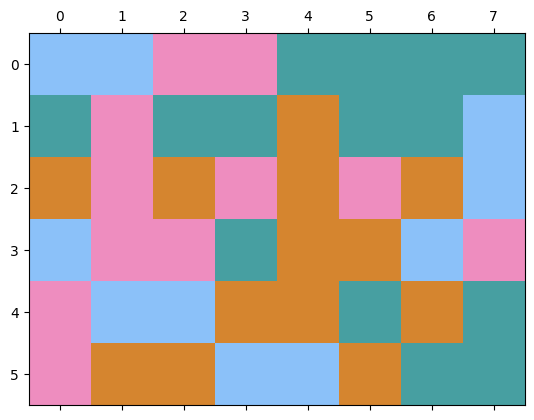

In [11]:
room = np.random.choice(4, 48).reshape((6,8))

n_emissions = room.max() + 1

a, x, rc = datagen_structured_obs_room(room, length=5000, seed=None)
a2, x2, rc2 = datagen_structured_obs_room(room, length=5000, seed=None)

n_clones = np.ones(n_emissions, dtype=np.int64) * 70

cmap = colors.ListedColormap(custom_colors[-4:])
plt.matshow(room, cmap=cmap)


In [13]:
chmm1 = CHMM(n_clones=n_clones, pseudocount=2e-3, x=x, a=a, seed=None)  # Initialize the model
progression = chmm1.learn_em_T(x, a, n_iter=1000)  # Training

chmm2 = CHMM(n_clones=n_clones, pseudocount=2e-3, x=x2, a=a2, seed=None)  # Initialize the model
progression2 = chmm2.learn_em_T(x2, a2, n_iter=1000)  # Training

Average number of clones: 70.0


 16%|█▋        | 163/1000 [00:53<04:32,  3.07it/s, train_bps=0.032]

Average number of clones: 70.0



 15%|█▌        | 154/1000 [00:44<04:04,  3.45it/s, train_bps=0.032]


In [14]:
# refine learning
chmm1.pseudocount = 0.0
v_prog = chmm1.learn_viterbi_T(x, a, n_iter=100)

chmm2.pseudocount = 0.0
v_prog2 = chmm2.learn_viterbi_T(x2, a2, n_iter=100)

100%|██████████| 100/100 [00:14<00:00,  6.95it/s, train_bps=0.00163]


# Compare learned maps

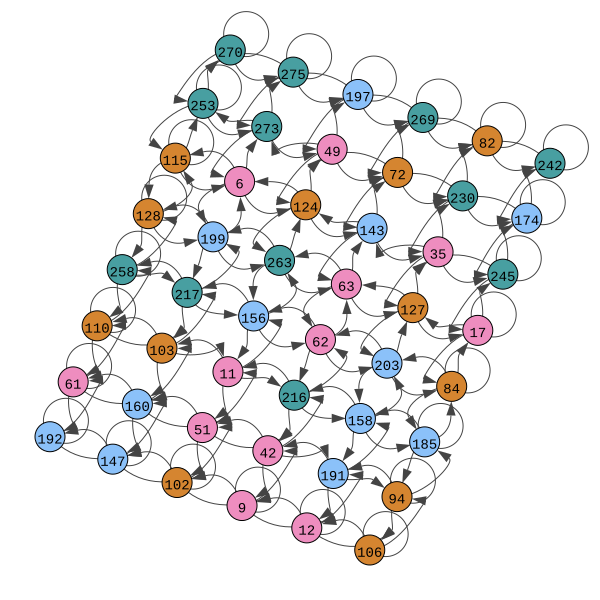

In [15]:
graph = plot_graph(
    chmm1, x, a, output_file="figures/chmm1_rectangular_room_graph.pdf", cmap=cmap
)
graph


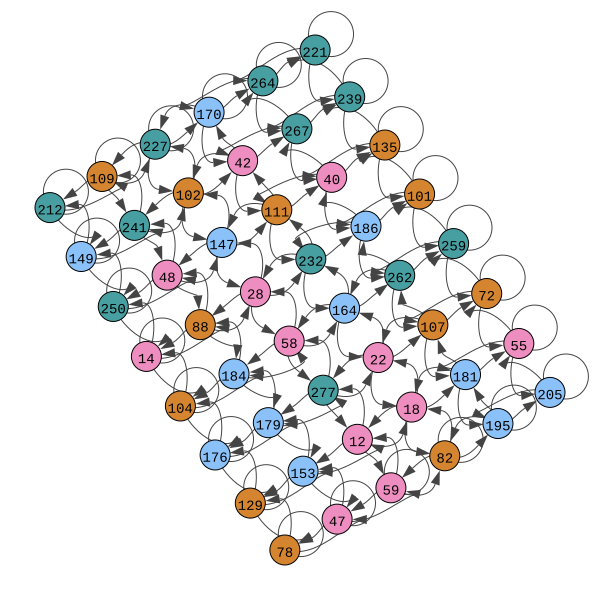

In [16]:
graph = plot_graph(
    chmm2, x2, a2, output_file="figures/chmm2_rectangular_room_graph.pdf", cmap=cmap
)
graph


In [18]:
# Get forward messages for a sequence
mess_fwd_chmm1 = get_mess_fwd(chmm1, x, pseudocount_E=0.1)
mess_fwd_chmm2 = get_mess_fwd(chmm2, x, pseudocount_E=0.1)

mess_fwd_chmm1_actions = get_mess_fwd(chmm1, x, a, pseudocount_E=0.1)
mess_fwd_chmm2_actions = get_mess_fwd(chmm2, x, a, pseudocount_E=0.1)

mess_fwd_chmm1x2 = get_mess_fwd(chmm1, x2, pseudocount_E=0.1)
mess_fwd_chmm2x2 = get_mess_fwd(chmm2, x2, pseudocount_E=0.1)

mess_fwd_chmm1x2_actions = get_mess_fwd(chmm1, x2, a2, pseudocount_E=0.1)
mess_fwd_chmm2x2_actions = get_mess_fwd(chmm2, x2, a2, pseudocount_E=0.1)

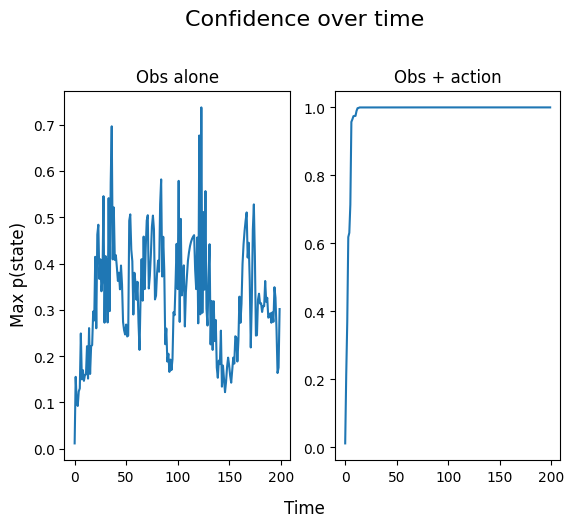

In [ ]:
# Plot certainty over time

fig, (ax1, ax2) = plt.subplots(1,2)

num_steps = 200

sequence = mess_fwd_chmm1[:num_steps]
sequence_actions = mess_fwd_chmm1_actions[:num_steps]

fig.suptitle('Confidence over time', fontsize=16, y=1.05)
ax1.plot(
    range(num_steps),
    np.max(sequence, axis=1)
)
_ = ax1.set_title("Obs alone")
# ax1.set(xlabel='time', ylabel='max(p(state|obs))')
ax2.plot(
    range(num_steps),
    np.max(sequence_actions, axis=1)
)
_ = ax2.set_title("Obs + action")
# ax2.set(xlabel='time', ylabel='max(p(state|obs, action))')

fig.text(0.5, 0.0, 'Time', ha='center', fontsize=12)
_ = fig.text(0.04, 0.5, 'Max p(state)', va='center', rotation='vertical', fontsize=12)


In [ ]:
# Average cosine similarity
avg_cs = torch.mean(cosine_sim(mess_fwd_chmm1, mess_fwd_chmm2))
print("Average cosine similarity across CHMM1 and CHMM2 messages:", avg_cs)

# Permuted cosine similarity
chmm1_mess_fwd_permuted = [sorted(t) for t in mess_fwd_chmm1]
chmm2_mess_fwd_permuted = [sorted(t) for t in mess_fwd_chmm2]

avg_cs_permuted = torch.mean(cosine_sim(chmm1_mess_fwd_permuted, chmm2_mess_fwd_permuted))
print("Average cosine similarity across CHMM1 and CHMM2 messages (sorted):", avg_cs_permuted)

Average cosine similarity across CHMM1 and CHMM2 messages: tensor(0.0848)
Average cosine similarity across CHMM1 and CHMM2 messages (sorted): tensor(1.)


In [19]:
# Construct a map
chmm1_sorted_indices = np.argsort(mess_fwd_chmm1)[-1]
chmm2_sorted_indices = np.argsort(mess_fwd_chmm2)[-1]

state_map = {s1: s2 for (s1, s2) in zip(chmm1_sorted_indices, chmm2_sorted_indices)}

state_idx = 45
print(f"CHMM2 state corresponding to state {state_idx} in CHMM1: {state_map[state_idx]}")

state_idx = 119
print(f"CHMM2 state corresponding to state {state_idx} in CHMM1: {state_map[state_idx]}")

CHMM2 state corresponding to state 45 in CHMM1: 73
CHMM2 state corresponding to state 119 in CHMM1: 106


In [20]:
# Reconstruct using map

def reconstruct_state(input_mess, target_mess, state_map):
    return np.array([target_mess[state_map[s]] for s in range(len(input_mess))])

chmm2_recon_perm = np.array(
    [
        np.array([reconstruct_state(s1, s2, state_map) for (s1, s2) in zip(mess_fwd_chmm1, mess_fwd_chmm2)])    
    ]
)

print("Reconstruction using permutations: ", torch.mean(cosine_sim(mess_fwd_chmm2, chmm2_recon_perm)))


Reconstruction using permutations:  tensor(0.6822)


# Create Relative Representations

In [21]:
def get_anchor_rrs(anchors):
    '''Get "relative anchors" i.e. relative representations for each anchor point
    (For use in deriving weights to reconstruct absolute representations)
    '''
    return cosine_sim(anchors, anchors, dim=None)
  

def reconstruct(Z, anchors, target_anchors, metric='cosine_sim', return_softmax=False, softmax_temp=0.01):
    rr = get_RR(Z, anchors, metric=metric)
    weights = softmax(rr/softmax_temp, axis=-1)
    recon = np.dot(weights, target_anchors)
    if return_softmax:
        return softmax(recon/softmax_temp)    
    return recon


def get_RR(X, anchors, metric='cosine_sim'):
    if metric == 'cosine_sim':
        return cosine_sim(X, anchors, dim=None)
    elif metric == 'jaccard':
        if len(X.shape) == 1:
            X = np.expand_dims(X, axis=0)
        min = np.sum(np.array([np.minimum(x, anchors) for x in X]), axis=-1)
        max = np.sum(np.array([np.maximum(x, anchors) for x in X]), axis=-1)
        return min / max
    else:
      raise ValueError("`metric` must be 'cosine_sim' or 'jaccard'")


def add_anchors(model_list:list[CHMM], x_list, a_list=None, pseudocount_E=0.1, num_anchors=1000, permute=True, filter=[None, None]):
    if type(x_list) != list:
        x_list = [x_list] * len(model_list)
    if type(a_list) != list:
        a_list = [a_list] * len(model_list)
    if num_anchors is not None:
        anchor_idxs = np.random.choice(len(x_list[0]), num_anchors, replace=False)
    else:
        anchor_idxs = slice(0, None, None)
        num_anchors = len(x_list[0])
    if permute:
        permutation = np.random.permutation(list(range(num_anchors)))
    for idx, model in enumerate(model_list):
        x = x_list[idx]
        a = a_list[idx] if a_list is not None else None
        mess_fwd = get_mess_fwd(model, x, a, pseudocount_E=pseudocount_E)
        anchors = mess_fwd[anchor_idxs]
        if permute:
            anchors = anchors[permutation]
        model.mess_fwd = torch.Tensor(mess_fwd)
        model.anchors = anchors

    return model_list


## Plot latent spaces

In [22]:
def _format_ax(ax, model_dict, model_type, idx, epsilon, num_classes, rep_type):
    ax.set_title(f"{model_type} {idx} {rep_type} representation")
    ax.tick_params(
        axis='both',          
        which='both',  
        bottom=False,  
        top=False,    
        left=False,
        labelleft=False,
        labelbottom=False)

def _plot_means(ax, model_dict, rep_type, epsilon, num_classes, model1_classes=None):
    abs_mean = model_dict[f'all_{rep_type[:3]}_mean']
    if model1_classes is not None:
        abs_mean = abs_mean[model1_classes]
    ax.scatter(abs_mean[:,0], abs_mean[:,1], color="black")
    numbers = model1_classes if model1_classes is not None else range(num_classes)
    [ax.annotate(text=n, xy=(abs_mean[idx,0] + epsilon, abs_mean[idx,1] + epsilon)) for idx, n in enumerate(numbers)]
    
def _get_rel_PCA(models_info, model_key, rtype, use_rel_PCA):
    return models_info[f'model{use_rel_PCA}']['rel_pca'] if use_rel_PCA is not None else models_info[model_key][f'{rtype}_pca']
    
def _add_reps(models_info, idx, rep_type, use_rel_PCA:int=None):
    model_dict = models_info[idx]
    rtype = rep_type[:3]
    model_dict[f'all_{rtype}'] = torch.cat([t for k, t in model_dict[rtype].items()])
    model_dict[f'{rtype}_pca'].fit(model_dict[f'all_{rtype}'])    
    pca_to_use = _get_rel_PCA(models_info, idx, rtype, use_rel_PCA)
    model_dict[f'all_{rtype}_mean'] = pca_to_use.transform(
        torch.cat([t.unsqueeze(0) for k, t in model_dict[f'{rtype}_mean'].items()])
    )
    return model_dict
  
def plot_latents(models, use_rel_PCA:int=0, num_classes:int=4, model_type='CSCG', abs_epsilon=0.01, rel_epsilon=.3, model1_classes=list(range(4))):

    num_models = len(models)
    models_info = {
        f'model{i}': {
            'model': models[i], 
            'abs_pca': PCA(n_components=2),
            'rel_pca': PCA(n_components=2),
            'abs': dict(),
            'rel': dict(),
            'abs_mean': dict(),
            'rel_mean': dict(),
            'mess_fwd': models[i].mess_fwd,
            'obs_seq': models[i].obs_seq,
            'anchors': models[i].anchors
        }
        for i in range(len(models))
    }

    fig, (abs_axs, rel_axs) = plt.subplots(2, num_models)

    for idx, (key, model_dict) in enumerate(models_info.items()):
        model_dict = models_info[key]
        for n in range(num_classes):
            n_idxs = model_dict['obs_seq'] == n
            model_dict['abs'][n] = model_dict['mess_fwd'][n_idxs]
            model_dict['abs_mean'][n] = torch.mean(model_dict['abs'][n], dim=0)
            model_dict['rel'][n] = get_RR(model_dict['abs'][n], model_dict['anchors'])
            model_dict['rel_mean'][n] = torch.mean(model_dict['rel'][n], dim=0)
            models_info[key] = model_dict

        models_info[key] = _add_reps(models_info, key, 'abs')
        models_info[key] = _add_reps(models_info, key, 'rel', 0)

        for n in range(num_classes):
            abs_rep_2d = models_info[key]['abs_pca'].transform(models_info[key]['abs'][n]) #[:100]
            abs_axs[idx].scatter(abs_rep_2d[:,0], abs_rep_2d[:,1])

            rel_pca = _get_rel_PCA(models_info, key, 'rel', use_rel_PCA)
            rel_rep_2d = rel_pca.transform(models_info[key]['rel'][n]) #[:100]
            rel_axs[idx].scatter(rel_rep_2d[:,0], rel_rep_2d[:,1])

        ax = abs_axs[idx]
        _format_ax(ax, model_dict, model_type, idx, abs_epsilon, num_classes, 'absolute')
        _plot_means(ax, model_dict, 'abs', abs_epsilon, num_classes, model1_classes if idx == 0 else None)
        ax = rel_axs[idx]
        _format_ax(ax, model_dict, model_type, idx, rel_epsilon, num_classes, 'relative')
        _plot_means(ax, model_dict, 'rel', rel_epsilon, num_classes, model1_classes if idx == 0 else None)

    fig.set_figwidth(10)
    fig.set_figheight(10)
                      

In [23]:
chmm1, chmm2 = add_anchors([chmm1, chmm2], x, permute=True)

# Use actions
# chmm1, chmm2 = add_anchors([chmm1, chmm2], x, a, permute=True)

## Plot representational similarity matrices

torch.Size([5000, 1000])
torch.Size([5000, 5000])


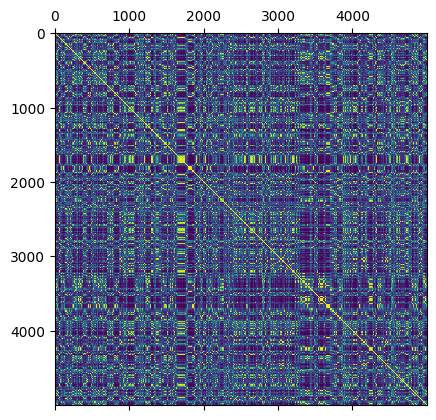

In [24]:
rr1 = get_RR(mess_fwd_chmm1x2, chmm1.anchors)
rr2 = get_RR(mess_fwd_chmm2x2, chmm2.anchors)
print(rr1.shape)
mat = cosine_sim(rr1, rr2, dim=None)
print(mat.shape)
plt.matshow(mat)

## Test reconstruction accuracy

In [ ]:
anchor_Ns = [280, 500, 1000, 2000, 3000, 4000, 5000]

cosine_sims = []

for N in anchor_Ns:
    print(f"Performing reconstruction test with {N} anchors...")
    chmm1, chmm2 = add_anchors([chmm1, chmm2], x, num_anchors=N)
    mess_fwd_recon = reconstruct(mess_fwd_chmm1, chmm1.anchors, chmm2.anchors, return_softmax=False)
    cosine_sims.append(
        torch.mean(cosine_sim(mess_fwd_chmm2, mess_fwd_recon))
    )

Performing reconstruction test with 280 anchors...
Performing reconstruction test with 500 anchors...
Performing reconstruction test with 1000 anchors...
Performing reconstruction test with 2000 anchors...
Performing reconstruction test with 3000 anchors...
Performing reconstruction test with 4000 anchors...
Performing reconstruction test with 5000 anchors...


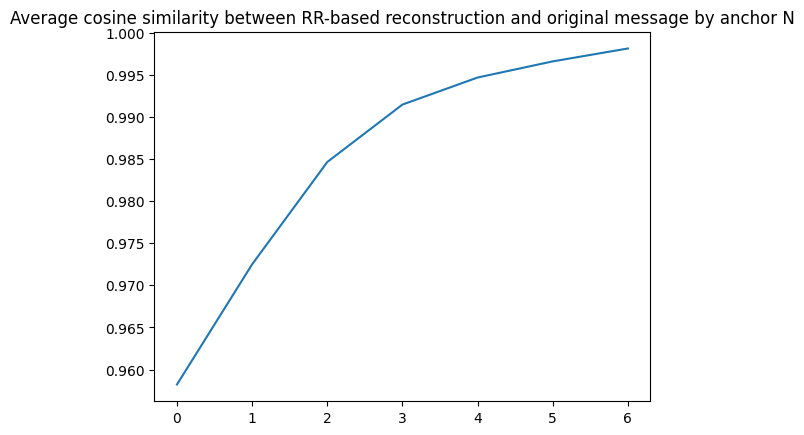

In [ ]:
plt.plot(range(len(cosine_sims)), cosine_sims)
plt.title("Average cosine similarity between message and RR-based reconstruction by anchor N")
plt.xlabel("Number of anchors")
plt.ylable("Cosine similarity")
# plt.xticks(anchor_Ns)
plt.show()

In [ ]:
mess_fwd_recon = reconstruct(mess_fwd_chmm1, chmm1.anchors, chmm2.anchors, return_softmax=False)

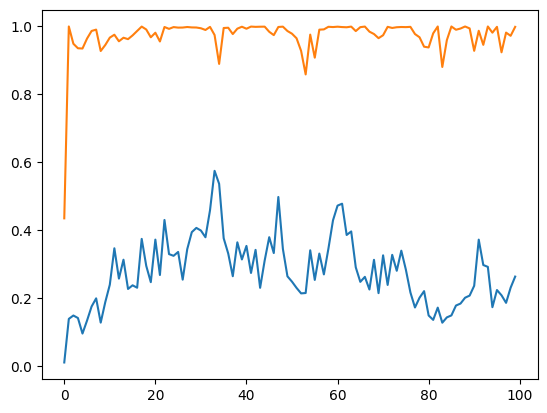

In [ ]:
# Plot accuracy of reconstruction over time

num_steps = 100

sequence = mess_fwd_chmm1[:num_steps]
similarities = cosine_sim(mess_fwd_chmm2, mess_fwd_recon,dim=-1)

mess_fwd_chmm1_actions[:num_steps]

plt.plot(
    range(num_steps),
    np.max(sequence, axis=1)
)
plt.plot(
    range(num_steps),
    similarities[:num_steps]
)

In [ ]:
chmm1_maxes = np.argmax(mess_fwd_chmm1,axis=1)
chmm2_maxes = np.argmax(mess_fwd_chmm2,axis=1)

chmm1, chmm2 = add_anchors([chmm1, chmm2], x, num_anchors=5000)
mess_fwd_recon = reconstruct(mess_fwd_chmm1, chmm1.anchors, chmm2.anchors, return_softmax=False)

rr_reconstructed_maxes = np.argmax(mess_fwd_recon,axis=1)

map_recon = np.array([state_map[s] for s in chmm1_maxes])

print("Accuracy using permutations: ", f"{sum(chmm2_maxes == map_recon)/len(mess_fwd_recon)*100}%")
print("Accuracy using RRs: ", f"{sum(chmm2_maxes == rr_reconstructed_maxes)/len(mess_fwd_recon)*100}%")

Accuracy using permutations:  99.98%
Accuracy using RRs:  96.3%


In [ ]:
mess_fwd_x2_recon = reconstruct(mess_fwd_chmm1x2, chmm1.anchors, chmm2.anchors, return_softmax=False)

rr_reconstructed_maxes_x2 = np.argmax(mess_fwd_x2_recon,axis=1)

chmm1_maxes_x2 = np.argmax(mess_fwd_chmm1x2,axis=1)
chmm2_maxes_x2 = np.argmax(mess_fwd_chmm2x2,axis=1)

map_recon_x2 = np.array([state_map[s] for s in chmm1_maxes_x2])

print("Accuracy using permutations (distinct test sequence): ", f"{sum(chmm2_maxes_x2 == map_recon_x2)/len(mess_fwd_x2_recon)*100}%")
print("Accuracy using RRs (distinct test sequence): ", f"{sum(chmm2_maxes_x2 == rr_reconstructed_maxes_x2)/len(mess_fwd_x2_recon)*100}%")


Accuracy using permutations (distinct test sequence):  99.98%
Accuracy using RRs (distinct test sequence):  88.48%


In [ ]:
# Accuracy of reconstruction over time

recon_map = np.array(
    [
        np.array([reconstruct_state(s1, s2, state_map) for (s1, s2) in zip(mess_fwd_chmm1x2_actions, mess_fwd_chmm2x2_actions)])    
    ]
)
print("Reconstruction using permutations: ", torch.mean(cosine_sim(mess_fwd_chmm2x2_actions, recon_map)))


similarities_1 = cosine_sim(mess_fwd_x2_recon_a, mess_fwd_chmm2x2_actions, dim=-1)
print("Cosine sim 1->2: ", torch.mean(similarities_1))


(5000,)
(5000, 280)
Reconstruction using permutations:  tensor(0.9571)
Cosine sim 1->2:  tensor(0.9996)


### Plot RRs

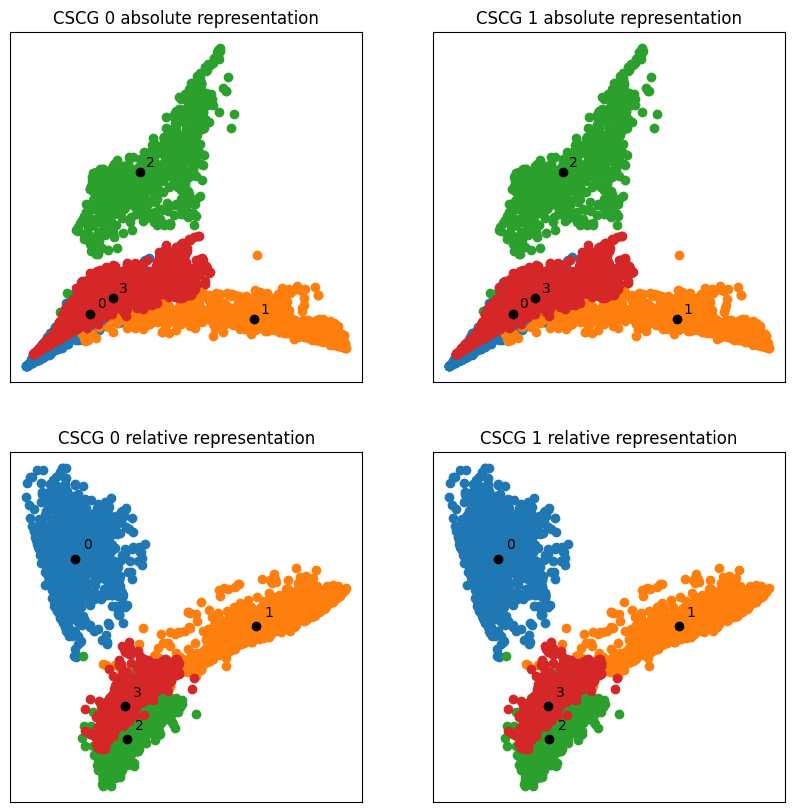

In [ ]:
plot_latents([chmm1, chmm2])

# Dissimilar rooms

### Expanded room

([], [])

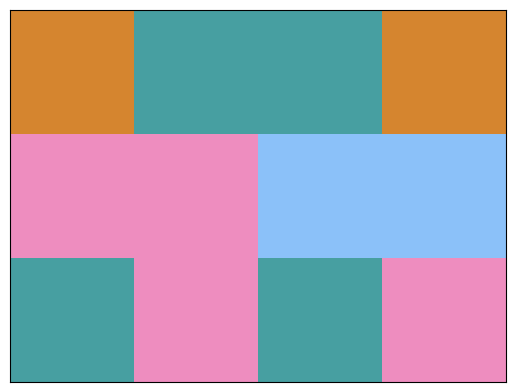

In [ ]:
small_room = np.random.choice(4, 3*4).reshape((3,4))
expanded_room = np.kron(small_room, np.ones((2,2), dtype='int'))


plt.matshow(small_room, cmap=cmap)
plt.xticks([])
plt.yticks([])

In [ ]:
# Train CSCGs on small/expanded rooms

a_s, x_s, rc_s = datagen_structured_obs_room(small_room, length=10000, seed=None)
a_e, x_e, rc_e = datagen_structured_obs_room(expanded_room, length=10000, seed=None)

n_clones = np.ones(n_emissions, dtype=np.int64) * 70

chmm_s = CHMM(n_clones=n_clones, pseudocount=2e-3, x=x_s, a=a_s, seed=None)
progression_s = chmm_s.learn_em_T(x_s, a_s, n_iter=1000)
chmm_e = CHMM(n_clones=n_clones, pseudocount=2e-3, x=x_e, a=a_e, seed=None)
progression_e = chmm_e.learn_em_T(x_e, a_e, n_iter=1000)

chmm_s.pseudocount = 0.0
v_prog_s = chmm_s.learn_viterbi_T(x_s, a_s, n_iter=100)
chmm_e.pseudocount = 0.0
v_prog_e = chmm_e.learn_viterbi_T(x_e, a_e, n_iter=100)

Average number of clones: 70.0


 60%|█████▉    | 596/1000 [05:43<03:52,  1.74it/s, train_bps=0.00456]

Average number of clones: 70.0



100%|██████████| 100/100 [00:28<00:00,  3.51it/s, train_bps=0.000813]


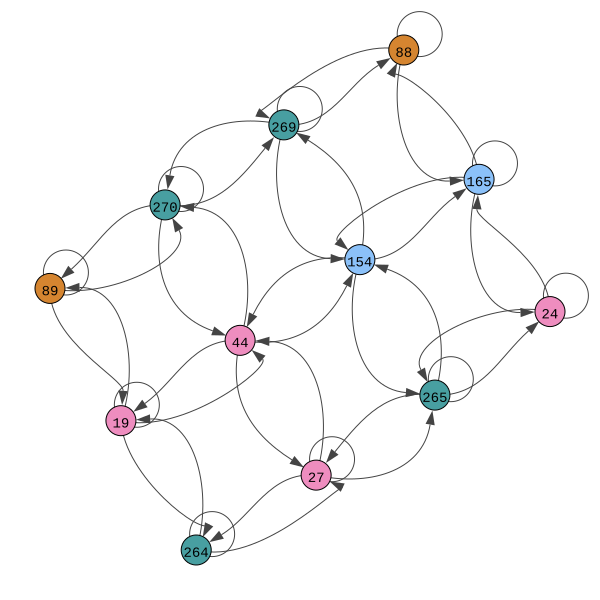

In [ ]:
graph = plot_graph(
    chmm_s, x_s, a_s, output_file="figures/small_room_graph.pdf", cmap=cmap
)
graph


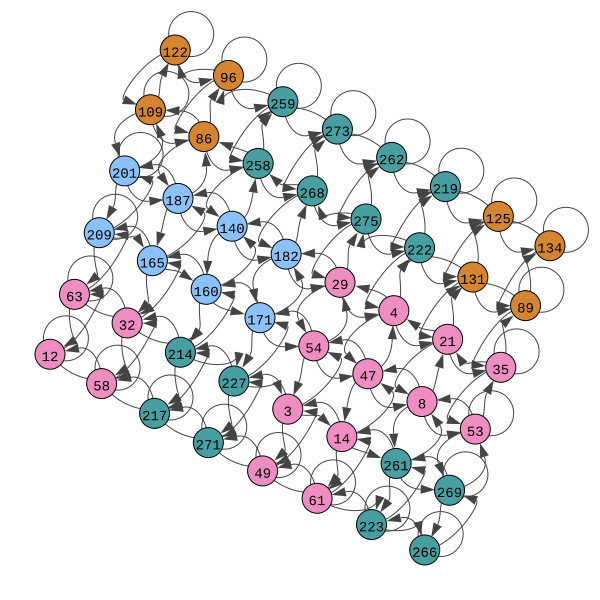

In [ ]:
graph = plot_graph(
    chmm_e, x_e, a_e, output_file="figures/expanded_room_graph.pdf", cmap=cmap
)
graph


In [ ]:
# Anchor sequences

act_seq_small, obs_seq_small, rc_small = datagen_structured_obs_room(
    small_room,
    start_r = 0,
    start_c = 0,
    no_left=[],
    no_right=[],
    no_up=[],
    no_down=[],
    length=5000
)

act_seq_expanded = np.squeeze(np.kron(act_seq_small, np.ones((1,2), dtype='int'))) #[1:]

_, obs_seq_expanded, rc_expanded = datagen_structured_obs_room(
    expanded_room,
    start_r=0,
    start_c=0,
    no_left=[],
    no_right=[],
    no_up=[],
    no_down=[],
    length=None,
    actions=act_seq_expanded,
)


In [ ]:
# Test sequences

act_seq_small2, obs_seq_small2, rc_small2 = datagen_structured_obs_room(
    small_room,
    start_r = 0,
    start_c = 0,
    no_left=[],
    no_right=[],
    no_up=[],
    no_down=[],
    length=5000,
    seed=None
)

act_seq_expanded2 = np.squeeze(np.kron(act_seq_small2, np.ones((1,2), dtype='int')))

_, obs_seq_expanded2, rc_expanded2 = datagen_structured_obs_room(
    expanded_room,
    start_r=0,
    start_c=0,
    no_left=[],
    no_right=[],
    no_up=[],
    no_down=[],
    length=None,
    seed=None,
    actions=act_seq_expanded2,
)


In [ ]:
s_mess_fwd = get_mess_fwd(chmm_s, obs_seq_small, act_seq_small, pseudocount_E=0.1)
e_mess_fwd = get_mess_fwd(chmm_e, obs_seq_expanded, act_seq_expanded, pseudocount_E=0.1)

s_mess_fwd2 = get_mess_fwd(chmm_s, obs_seq_small2, act_seq_small2, pseudocount_E=0.1)
e_mess_fwd2 = get_mess_fwd(chmm_e, obs_seq_expanded2, act_seq_expanded2, pseudocount_E=0.1)

e_mess_fwd_subsampled = e_mess_fwd[::2]

chmm_s.anchors = s_mess_fwd
chmm_e.anchors = e_mess_fwd_subsampled

In [ ]:
s_recon = reconstruct(chmm_e.anchors, chmm_e.anchors, chmm_s.anchors)
e_recon = reconstruct(s_mess_fwd, chmm_s.anchors, chmm_e.anchors)
similarities_s = cosine_sim(s_mess_fwd, s_recon, dim=-1)
similarities_e = cosine_sim(chmm_e.anchors, e_recon, dim=-1)

In [ ]:
s_maxes = np.argmax(s_mess_fwd,axis=1)
e_maxes = np.argmax(e_mess_fwd_subsampled,axis=1)

s_recon_maxes = np.argmax(s_recon,axis=1)
e_recon_maxes = np.argmax(e_recon,axis=1)

print("Accuracy translating across `small` and `expanded` room maps using RRs: ", f"{sum(s_maxes == s_recon_maxes)/len(s_maxes)*100}%")
print("Accuracy in reverse direction (expanded -> small): ", f"{sum(e_maxes == e_recon_maxes)/len(e_maxes)*100}%")

print("Average cosine similarity (small-room messages VS reconstruction)", torch.mean(cosine_sim(s_mess_fwd, s_recon)))
print("Average cosine similarity (large-room messages VS reconstruction)", torch.mean(cosine_sim(e_mess_fwd_subsampled, e_recon)))

Accuracy translating across `small` and `expanded` room maps using RRs:  87.83999999999999%
Accuracy in reverse direction (expanded -> small):  62.419999999999995%
Average cosine similarity (small-room messages VS reconstruction) tensor(0.9870)
Average cosine similarity (large-room messages VS reconstruction) tensor(0.9261)


In [ ]:
# Test

s2_maxes = np.argmax(s_mess_fwd2,axis=1)
e2_maxes = np.argmax(e_mess_fwd2[::2], axis=1)

e_mess_fwd2_subsampled = e_mess_fwd2[::2]

s2_recon = reconstruct(e_mess_fwd2_subsampled, chmm_e.anchors, chmm_s.anchors)
e2_recon = reconstruct(s_mess_fwd2, chmm_s.anchors, chmm_e.anchors)


s2_recon_maxes = np.argmax(s2_recon,axis=1)
e2_recon_maxes = np.argmax(e2_recon,axis=1)

print("Accuracy translating across `small` and `expanded` room maps using RRs: ", f"{sum(s2_maxes == s2_recon_maxes)/len(s2_maxes)*100}%")
print("Accuracy in reverse direction (expanded -> small): ", f"{sum(e2_maxes == e2_recon_maxes)/len(e2_maxes)*100}%")

Accuracy translating across `small` and `expanded` room maps using RRs:  86.4%
Accuracy in reverse direction (expanded -> small):  61.260000000000005%


In [ ]:
# Test w/precise beliefs

s_maxes = np.argmax(s_mess_fwd2,axis=1)
e_maxes = np.argmax(e_mess_fwd2_subsampled,axis=1)

s_recon_maxes = np.argmax(s_recon3,axis=1)
e_recon_maxes = np.argmax(e_recon3,axis=1)

print("Accuracy translating across `small` and `expanded` room maps using RRs: ", f"{sum(s_maxes == s_recon_maxes)/len(s_maxes)*100}%")
print("Accuracy in reverse direction (expanded -> small): ", f"{sum(e_maxes == e_recon_maxes)/len(e_maxes)*100}%")

# Average cosine similarity
print("Average cosine similarity (small-room messages VS reconstruction)", torch.mean(cosine_sim(s_mess_fwd2, s_recon3)))
print("Average cosine similarity (large-room messages VS reconstruction)", torch.mean(cosine_sim(e_mess_fwd_subsampled2, e_recon3)))

Accuracy translating across `small` and `expanded` room maps using RRs:  97.52%
Accuracy in reverse direction (expanded -> small):  48.78%
Average cosine similarity (small-room messages VS reconstruction) tensor(0.9768)
Average cosine similarity (large-room messages VS reconstruction) tensor(0.6070)


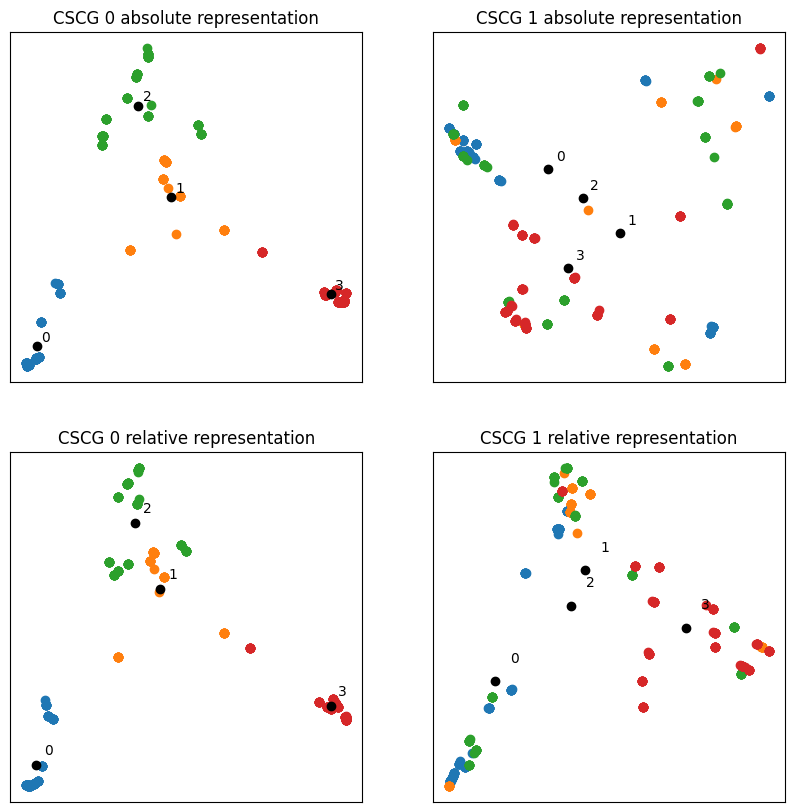

In [ ]:
# Try plotting
plot_latents([chmm_s, chmm_e])

### Shifted rooms

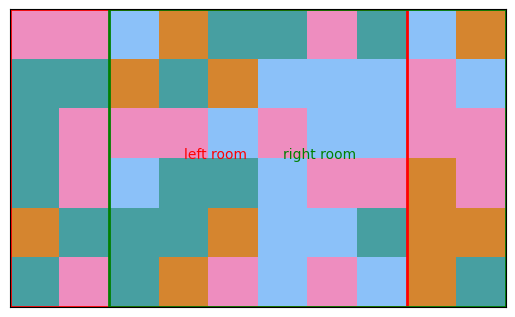

In [ ]:
big_room = np.random.choice(4, 6*10).reshape((6,10))
left_room = big_room[:, :8]
right_room = big_room[:, 2:]

fig, ax = plt.subplots()

_ = ax.matshow(big_room, cmap=cmap)
left_box = patches.Rectangle((-0.5, -0.5), 8, 6, linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(left_box)
_ = ax.annotate("left room", (3, 2.5), color='red')

right_box = patches.Rectangle((2 -0.5, -0.5), 8, 6, linewidth=2, edgecolor='g', facecolor='none')
ax.add_patch(right_box)
_ = ax.annotate("right room", (5, 2.5), color='green')
_ = ax.set_xticks([])
_ = ax.set_yticks([])


In [ ]:
# Train CSCGs on shifted rooms

a_l, x_l, rc_l = datagen_structured_obs_room(left_room, length=10000, seed=None)
a_r, x_r, rc_r = datagen_structured_obs_room(right_room, length=10000, seed=None)

n_clones = np.ones(n_emissions, dtype=np.int64) * 70

chmm_l = CHMM(n_clones=n_clones, pseudocount=2e-3, x=x_l, a=a_l, seed=None)
progression_l = chmm_l.learn_em_T(x_l, a_l, n_iter=1000)
chmm_r = CHMM(n_clones=n_clones, pseudocount=2e-3, x=x_r, a=a_r, seed=None)
progression_r = chmm_r.learn_em_T(x_r, a_r, n_iter=1000)

chmm_l.pseudocount = 0.0
v_prog_l = chmm_l.learn_viterbi_T(x_l, a_l, n_iter=100)
chmm_r.pseudocount = 0.0
v_prog_r = chmm_r.learn_viterbi_T(x_r, a_r, n_iter=100)

Average number of clones: 70.0


 12%|█▎        | 125/1000 [01:09<08:05,  1.80it/s, train_bps=0.0467]

Average number of clones: 70.0



100%|██████████| 100/100 [00:28<00:00,  3.54it/s, train_bps=0.000971]


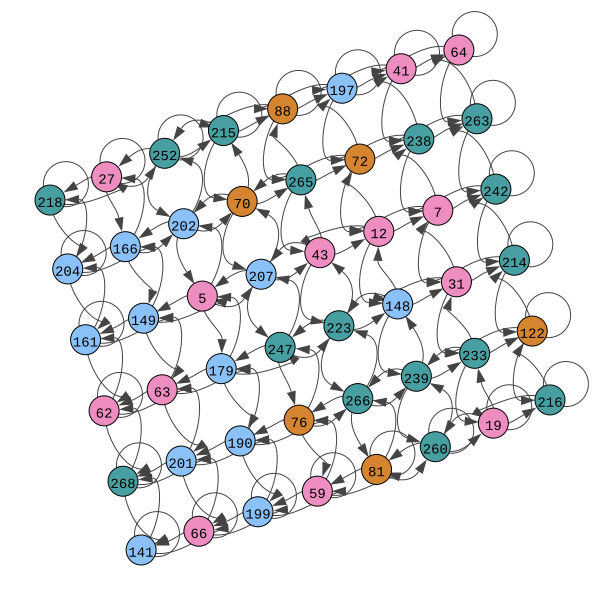

In [ ]:
graph = plot_graph(
    chmm_l, x_l, a_l, output_file="figures/left_room_graph.pdf", cmap=cmap
)
graph

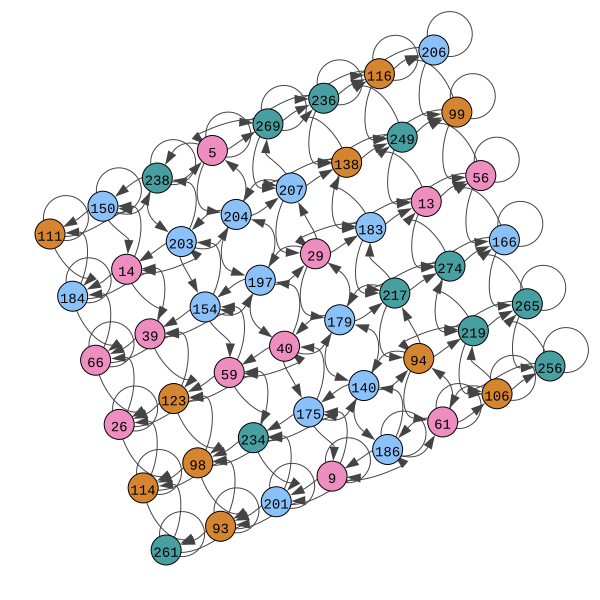

In [ ]:
graph = plot_graph(
    chmm_r, x_r, a_r, output_file="figures/right_room_graph.pdf", cmap=cmap
)
graph

In [ ]:
# Get anchor sequences
act_seq_l, obs_seq_l, rc_l = datagen_structured_obs_room(
    left_room,
    start_r = 0,
    start_c = 0,
    no_left=[],
    no_right=[],
    no_up=[],
    no_down=[],
    length=5000,
    seed=None
)

act_seq_r, obs_seq_r, rc_r = datagen_structured_obs_room(
    right_room,
    start_r=0,
    start_c=0,
    no_left=[],
    no_right=[],
    no_up=[],
    no_down=[],
    length=None,
    seed=None,
    actions=act_seq_l,
)

# Test sequences
act_seq_l2, obs_seq_l2, rc_l2 = datagen_structured_obs_room(
    left_room,
    start_r = 0,
    start_c = 0,
    no_left=[],
    no_right=[],
    no_up=[],
    no_down=[],
    length=5000,
    seed=None
)

act_seq_r2, obs_seq_r2, rc_r2 = datagen_structured_obs_room(
    right_room,
    start_r=0,
    start_c=0,
    no_left=[],
    no_right=[],
    no_up=[],
    no_down=[],
    length=None,
    seed=None,
    actions=act_seq_l2,
)


In [ ]:
chmm_l, chmm_r = add_anchors([chmm_l, chmm_r], [obs_seq_l, obs_seq_r], num_anchors=5000, permute=True)

l_mess_fwd = get_mess_fwd(chmm_l, obs_seq_l, pseudocount_E=0.1)
r_mess_fwd = get_mess_fwd(chmm_r, obs_seq_r, pseudocount_E=0.1)

l_mess_fwd2 = get_mess_fwd(chmm_l, obs_seq_l2, pseudocount_E=0.1)
r_mess_fwd2 = get_mess_fwd(chmm_r, obs_seq_r2, pseudocount_E=0.1)

l_mess_fwd_a = get_mess_fwd(chmm_l, obs_seq_l, act_seq_l, pseudocount_E=0.1)
r_mess_fwd_a = get_mess_fwd(chmm_r, obs_seq_r, act_seq_r, pseudocount_E=0.1)

l_mess_fwd2_a = get_mess_fwd(chmm_l, obs_seq_l2, act_seq_l2, pseudocount_E=0.1)
r_mess_fwd2_a = get_mess_fwd(chmm_r, obs_seq_r2, act_seq_r2, pseudocount_E=0.1)

In [ ]:
r_recon = reconstruct(l_mess_fwd, chmm_l.anchors, chmm_r.anchors)
l_recon = reconstruct(r_mess_fwd, chmm_r.anchors, chmm_l.anchors)

similarities_l = cosine_sim(l_mess_fwd, l_recon, dim=-1)
similarities_r = cosine_sim(r_mess_fwd, r_recon, dim=-1)

In [ ]:
act_l2, obs_l2, rc_l2 = datagen_structured_obs_room(
    left_room,
    start_r=0,
    start_c=0,
    no_left=[],
    no_right=[],
    no_up=[],
    no_down=[],
    length=10000,
)

act_r2, obs_r2, rc_r2 = datagen_structured_obs_room(
    right_room,
    start_r=0,
    start_c=0,
    no_left=[],
    no_right=[],
    no_up=[],
    no_down=[],
    length=None,
    actions = act_l2
)

l_mess_fwd2 = get_mess_fwd(chmm_l, obs_l2, pseudocount_E=0.1)
r_mess_fwd2 = get_mess_fwd(chmm_r, obs_r2, pseudocount_E=0.1)





In [ ]:
l_mess_fwd = get_mess_fwd(chmm_l, obs_seq_l, pseudocount_E=0.1)
r_mess_fwd = get_mess_fwd(chmm_r, obs_seq_r, pseudocount_E=0.1)

l_mess_fwd2 = get_mess_fwd(chmm_l, obs_seq_l2, pseudocount_E=0.1)
r_mess_fwd2 = get_mess_fwd(chmm_r, obs_seq_r2, pseudocount_E=0.1)


In [ ]:
r_recon = reconstruct(l_mess_fwd, chmm_l.anchors, chmm_r.anchors)
l_recon = reconstruct(r_mess_fwd, chmm_r.anchors, chmm_l.anchors)
r_recon2 = reconstruct(l_mess_fwd2, chmm_l.anchors, chmm_r.anchors)
l_recon2 = reconstruct(r_mess_fwd2, chmm_r.anchors, chmm_l.anchors)

l_maxes = np.argmax(l_mess_fwd,axis=1)
r_maxes = np.argmax(r_mess_fwd,axis=1)

l_recon_maxes = np.argmax(l_recon,axis=1)
r_recon_maxes = np.argmax(r_recon,axis=1)

l_maxes2 = np.argmax(l_mess_fwd2,axis=1)
r_maxes2 = np.argmax(r_mess_fwd2,axis=1)

l_recon_maxes2 = np.argmax(l_recon2,axis=1)
r_recon_maxes2 = np.argmax(r_recon2,axis=1)

print("Accuracy translating across `left` and `right` room maps using RRs (same anchors): ", f"{sum(l_maxes == l_recon_maxes)/len(l_maxes)*100}%")
print("Accuracy in reverse direction (right -> left) (same anchors): ", f"{sum(r_maxes == r_recon_maxes)/len(r_maxes)*100}%")

print("Accuracy translating across `left` and `right` room maps using RRs: ", f"{sum(l_maxes2 == l_recon_maxes2)/len(l_maxes2)*100}%")
print("Accuracy in reverse direction (right -> left): ", f"{sum(r_maxes2 == r_recon_maxes2)/len(r_maxes2)*100}%")

Accuracy translating across `left` and `right` room maps using RRs (same anchors):  4.32%
Accuracy in reverse direction (right -> left) (same anchors):  5.5%
Accuracy translating across `left` and `right` room maps using RRs:  3.56%
Accuracy in reverse direction (right -> left):  4.84%


In [ ]:
chmm_l, chmm_r = add_anchors([chmm_l, chmm_r], [obs_seq_l, obs_seq_r], [act_seq_l, act_seq_r], num_anchors=5000, permute=True)

r_recon_a = reconstruct(l_mess_fwd_a, chmm_l.anchors, chmm_r.anchors)
l_recon_a = reconstruct(r_mess_fwd_a, chmm_r.anchors, chmm_l.anchors)
r_recon2_a = reconstruct(l_mess_fwd2_a, chmm_l.anchors, chmm_r.anchors)
l_recon2_a = reconstruct(r_mess_fwd2_a, chmm_r.anchors, chmm_l.anchors)

l_maxes_a = np.argmax(l_mess_fwd_a,axis=1)
r_maxes_a = np.argmax(r_mess_fwd_a,axis=1)

l_recon_maxes_a = np.argmax(l_recon_a,axis=1)
r_recon_maxes_a = np.argmax(r_recon_a,axis=1)

l_maxes2_a = np.argmax(l_mess_fwd2_a,axis=1)
r_maxes2_a = np.argmax(r_mess_fwd2_a,axis=1)

l_recon_maxes2_a = np.argmax(l_recon2_a,axis=1)
r_recon_maxes2_a = np.argmax(r_recon2_a,axis=1)

print("Accuracy translating across `left` and `right` room maps using RRs (same anchors): ", f"{sum(l_maxes_a == l_recon_maxes_a)/len(l_maxes_a)*100}%")
print("Accuracy in reverse direction (right -> left) (same anchors): ", f"{sum(r_maxes_a == r_recon_maxes_a)/len(r_maxes_a)*100}%")

print("Accuracy translating across `left` and `right` room maps using RRs: ", f"{sum(l_maxes2_a == l_recon_maxes2_a)/len(l_maxes2_a)*100}%")
print("Accuracy in reverse direction (right -> left): ", f"{sum(r_maxes2_a == r_recon_maxes2_a)/len(r_maxes2_a)*100}%")

Accuracy translating across `left` and `right` room maps using RRs (same anchors):  100.0%
Accuracy in reverse direction (right -> left) (same anchors):  97.8%
Accuracy translating across `left` and `right` room maps using RRs:  99.94%
Accuracy in reverse direction (right -> left):  97.7%


In [ ]:
# Average cosine similarity
print("Average cosine similarity l -> r (imprecise; diff)", torch.mean(cosine_sim(l_mess_fwd2, l_recon2)))
print("Average cosine similarity r -> l", torch.mean(cosine_sim(r_mess_fwd2, r_recon2)))

print("Average cosine similarity l -> r (precise; diff)", torch.mean(cosine_sim(l_mess_fwd2_a, l_recon2_a)))
print("Average cosine similarity r -> l", torch.mean(cosine_sim(r_mess_fwd2_a, r_recon2_a)))

In [ ]:
# Average cosine similarity
print("Average cosine similarity (small-room messages VS reconstruction)", torch.mean(cosine_sim(l_mess_fwd, l_recon)))
print("Average cosine similarity (large-room messages VS reconstruction)", torch.mean(cosine_sim(r_mess_fwd, r_recon)))

Average cosine similarity (small-room messages VS reconstruction) tensor(0.9651)
Average cosine similarity (large-room messages VS reconstruction) tensor(0.9400)


In [ ]:
# Since the rooms are the same size, we can try the permutation method
l_sorted_indices = np.argsort(l_mess_fwd)[-1]
r_sorted_indices = np.argsort(r_mess_fwd)[-1]

lr_state_map = {s1: s2 for (s1, s2) in zip(l_sorted_indices, r_sorted_indices)}

l_maxes = np.argmax(l_mess_fwd,axis=1)
r_maxes = np.argmax(r_mess_fwd,axis=1)

r_map_recon = np.array([lr_state_map[s] for s in l_maxes])

print("Mapping accuracy using permutations: ", f"{sum(r_maxes == r_map_recon)/len(r_mess_fwd)*100}%")

# Permuted cosine similarity
l_mess_fwd_permuted = [sorted(t) for t in l_mess_fwd]
r_mess_fwd_permuted = [sorted(t) for t in r_mess_fwd]

print("Cosine sim using permutations: ", torch.mean(cosine_sim(l_mess_fwd_permuted, r_mess_fwd_permuted)))

Mapping accuracy using permutations:  1.96%
Cosine sim using permutations:  tensor(0.9115)


In [ ]:
r_recon_perm = np.array(
    [
        np.array([reconstruct_state(s1, s2, lr_state_map) for (s1, s2) in zip(l_mess_fwd, r_mess_fwd)])    
    ]
)

torch.mean(cosine_sim(r_mess_fwd, r_recon_perm))

tensor(0.9028)

In [ ]:
# Average cosine similarity
print("Average cosine similarity (small-room messages VS reconstruction)", torch.mean(cosine_sim(l_mess_fwd2, l_recon2)))
print("Average cosine similarity (large-room messages VS reconstruction)", torch.mean(cosine_sim(r_mess_fwd2, r_recon2)))

Average cosine similarity (small-room messages VS reconstruction) tensor(0.3794)
Average cosine similarity (large-room messages VS reconstruction) tensor(0.3188)


### Landmarks

In [ ]:
rand_room1 = np.random.choice(4, 6*8).reshape((6,8)).astype('int64')
rand_room2 = np.random.choice(4, 6*8).reshape((6,8)).astype('int64')

rand_room1[0] = rand_room2[0] = 8
rand_room1[-1] = rand_room2[-1] = 9
rand_room1[:, 0] = rand_room2[:, 0] = 10
rand_room1[:, -1] = rand_room2[:, -1] = 11
rand_room1[0, 0] = rand_room2[0, 0] = 4
rand_room1[0, -1] = rand_room2[0, -1] = 5
rand_room1[-1, 0] = rand_room2[-1, 0] = 6
rand_room1[-1, -1] = rand_room2[-1, -1] = 7

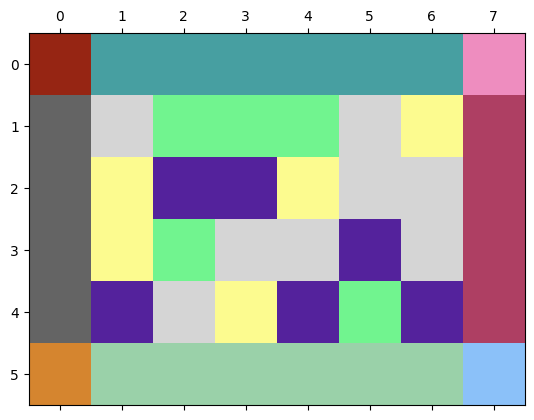

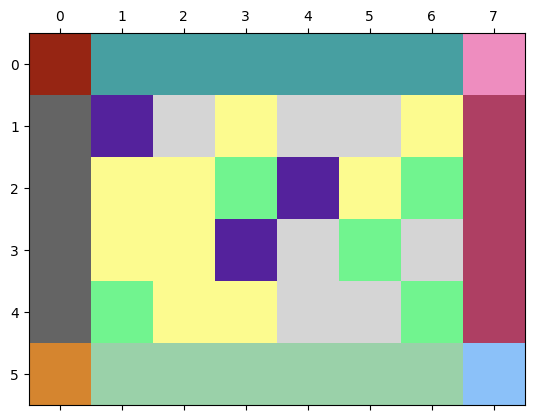

In [ ]:
custom_colors2 = (
    np.array(
        [
            [214, 214, 214],
            [85, 35, 157],
            [253, 252, 144],
            [114, 245, 144],
            [151, 38, 20],
            [239, 142, 192],
            [214, 134, 48],
            [140, 194, 250],
            [72, 160, 162],
            [155, 210, 170],
            [101, 101, 101],
            [175, 64, 100]
        ]
    )
    / 256
)
cmap2 = colors.ListedColormap(custom_colors2)
plt.matshow(rand_room1, cmap=cmap2)
plt.matshow(rand_room2, cmap=cmap2)

In [ ]:
border = np.ones((6, 8), dtype=int) * -1
border

border[0] = 8
border[-1] = 9
border[:, 0] = 10
border[:, -1] = 11
border[0, 0] = 4
border[0, -1] = 5
border[-1, 0] = 6
border[-1, -1] = 7

In [ ]:
n_emissions = rand_room1.max() + 1

a_rr1, x_rr1, rc_rr1 = datagen_structured_obs_room(rand_room1, length=10000)
a_rr2, x_rr2, rc_rr2 = datagen_structured_obs_room(rand_room2, length=10000)

n_clones = np.ones(n_emissions, dtype=np.int64) * 70
chmm_rr1 = CHMM(n_clones=n_clones, pseudocount=2e-3, x=x_rr1, a=a_rr1, seed=None)
progression = chmm_rr1.learn_em_T(x_rr1, a_rr1, n_iter=1000)
chmm_rr2 = CHMM(n_clones=n_clones, pseudocount=2e-3, x=x_rr1, a=a_rr1, seed=None)
progression = chmm_rr2.learn_em_T(x_rr2, a_rr2, n_iter=1000)

# refine learning
chmm_rr1.pseudocount = 0.0
chmm_rr1.learn_viterbi_T(x_rr1, a_rr1, n_iter=100)

chmm_rr2.pseudocount = 0.0
chmm_rr2.learn_viterbi_T(x_rr2, a_rr2, n_iter=100)

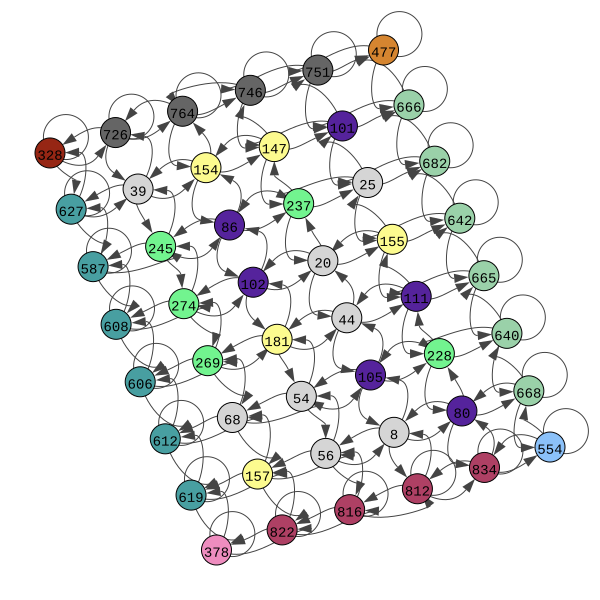

In [ ]:
graph = plot_graph(
    chmm_rr1, x_rr1, a_rr1, output_file="figures/rand_room_1_graph.pdf", cmap=cmap2
)
graph

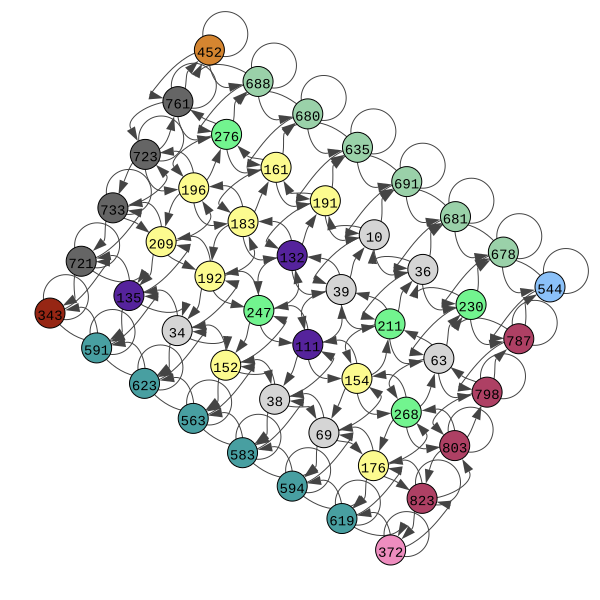

In [ ]:
graph = plot_graph(
    chmm_rr2, x_rr2, a_rr2, output_file="figures/rand_room_2_graph.pdf", cmap=cmap2
)
graph

In [ ]:
# Get limited set of border observations for anchors
b_a, b_o, b_rc = datagen_structured_obs_room(border, start_r=0, start_c=0, length=500, seed=None)
b_a3, b_o3, b_rc3 = datagen_structured_obs_room(rand_room1, start_r=0, start_c=0, length=500, seed=None)
b_a4, b_o4, b_rc4 = datagen_structured_obs_room(rand_room2, start_r=0, start_c=0, seed=None, length=None, actions=b_a3)


b_a2, b_o2, b_rc2 = datagen_structured_obs_room(
    border,
    start_r=0,
    start_c=0,
    no_left=[],
    no_right=[],
    no_up=[],
    no_down=[],
    length=None,
    seed=None,
    actions=b_a,
)

chmm_rr1, chmm_rr2 = add_anchors([chmm_rr1, chmm_rr2], [b_o, b_o2], num_anchors=500)


In [ ]:
# Plot accuracy of reconstruction over time

rr_mess_fwd1 = get_mess_fwd(chmm_rr1, b_o3, pseudocount_E=0.1)
rr_mess_fwd2 = get_mess_fwd(chmm_rr2, b_o4, pseudocount_E=0.1)

rr2_recon = reconstruct(rr_mess_fwd1, chmm_rr1.anchors, chmm_rr2.anchors)
rr1_recon = reconstruct(rr_mess_fwd2, chmm_rr2.anchors, chmm_rr1.anchors)
similarities_1 = cosine_sim(rr_mess_fwd1, rr1_recon, dim=-1)
similarities_2 = cosine_sim(rr_mess_fwd2, rr2_recon, dim=-1)

rr1_maxes = np.argmax(rr_mess_fwd1,axis=1)
rr2_maxes = np.argmax(rr_mess_fwd2,axis=1)

rr1_recon_maxes = np.argmax(rr1_recon,axis=1)
rr2_recon_maxes = np.argmax(rr2_recon,axis=1)

print("Accuracy translating 1 --> 2:", f"{sum(rr1_maxes == rr1_recon_maxes)/len(rr1_maxes)*100}%")
print("Accuracy translating 2 --> 1: ", f"{sum(rr2_maxes == rr2_recon_maxes)/len(rr2_maxes)*100}%")

# Average cosine similarity
print("Average cosine similarity (room 1 VS reconstruction)", torch.mean(cosine_sim(rr_mess_fwd1, rr1_recon)))
print("Average cosine similarity (room 2 VS reconstruction)", torch.mean(cosine_sim(rr_mess_fwd2, rr2_recon)))

Accuracy translating 1 --> 2: 35.0%
Accuracy translating 2 --> 1:  35.0%
Average cosine similarity (room 1 VS reconstruction) tensor(0.5203)
Average cosine similarity (room 2 VS reconstruction) tensor(0.5196)


In [ ]:
# Precise beliefs

chmm_rr1, chmm_rr2 = add_anchors([chmm_rr1, chmm_rr2], [b_o, b_o2], [b_a, b_a2], num_anchors=500)

# Plot accuracy of reconstruction over time

rr_mess_fwd1 = get_mess_fwd(chmm_rr1, b_o3, b_a3, pseudocount_E=0.1)
rr_mess_fwd2 = get_mess_fwd(chmm_rr2, b_o4, b_a4, pseudocount_E=0.1)

rr2_recon = reconstruct(rr_mess_fwd1, chmm_rr1.anchors, chmm_rr2.anchors)
rr1_recon = reconstruct(rr_mess_fwd2, chmm_rr2.anchors, chmm_rr1.anchors)
similarities_1 = cosine_sim(rr_mess_fwd1, rr1_recon, dim=-1)
similarities_2 = cosine_sim(rr_mess_fwd2, rr2_recon, dim=-1)

rr1_maxes = np.argmax(rr_mess_fwd1,axis=1)
rr2_maxes = np.argmax(rr_mess_fwd2,axis=1)

rr1_recon_maxes = np.argmax(rr1_recon,axis=1)
rr2_recon_maxes = np.argmax(rr2_recon,axis=1)

print("Accuracy translating 1 --> 2:", f"{sum(rr1_maxes == rr1_recon_maxes)/len(rr1_maxes)*100}%")
print("Accuracy translating 2 --> 1: ", f"{sum(rr2_maxes == rr2_recon_maxes)/len(rr2_maxes)*100}%")

# Average cosine similarity
print("Average cosine similarity (room 1 VS reconstruction)", torch.mean(cosine_sim(rr_mess_fwd1, rr1_recon)))
print("Average cosine similarity (room 2 VS reconstruction)", torch.mean(cosine_sim(rr_mess_fwd2, rr2_recon)))

Accuracy translating 1 --> 2: 100.0%
Accuracy translating 2 --> 1:  100.0%
Average cosine similarity (room 1 VS reconstruction) tensor(1.0000)
Average cosine similarity (room 2 VS reconstruction) tensor(1.0000)


[1 2]


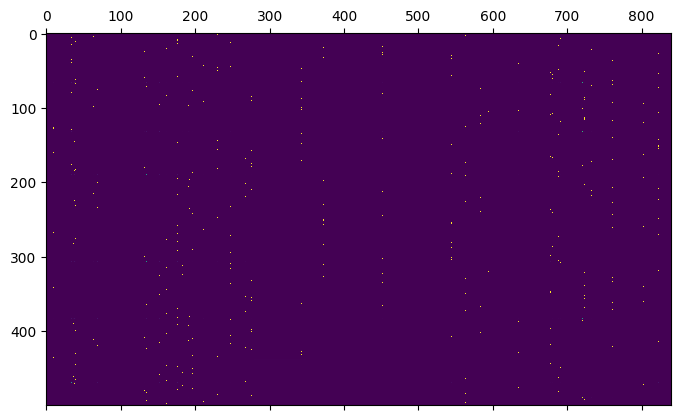

In [ ]:
# Visualize the RRs to get a sense of what's going on
def barplot(rep):
    plt.bar(range(len(rep)), rep)

rr2_recon[10][34]
print(b_rc3[10])
plt.matshow(chmm_rr2.anchors)

In [ ]:
# Since the rooms are the same size, we can try the permutation method
rr1_sorted_indices = np.argsort(rr_mess_fwd1)[-1]
rr2_sorted_indices = np.argsort(rr_mess_fwd2)[-1]

rr_state_map = {s1: s2 for (s1, s2) in zip(rr1_sorted_indices, rr2_sorted_indices)}

rr1_maxes = np.argmax(rr_mess_fwd1,axis=1)
rr2_maxes = np.argmax(rr_mess_fwd2,axis=1)

rr2_map_recon = np.array([rr_state_map[s] for s in rr1_maxes])

print("Mapping accuracy using permutations: ", f"{sum(rr2_maxes == rr2_map_recon)/len(rr_mess_fwd1)*100}%")

# Permuted cosine similarity
rr1_mess_fwd_permuted = [sorted(t) for t in rr_mess_fwd1]
rr2_mess_fwd_permuted = [sorted(t) for t in rr_mess_fwd2]

print("Cosine sim using permutations: ", torch.mean(cosine_sim(rr1_mess_fwd_permuted, rr2_mess_fwd_permuted)))

Mapping accuracy using permutations:  38.726790450928384%
Cosine sim using permutations:  tensor(0.9615)


In [ ]:
rr_recon_perm = np.array(
    [
        np.array([reconstruct_state(s1, s2, rr_state_map) for (s1, s2) in zip(rr_mess_fwd1, rr_mess_fwd2)])    
    ]
)

torch.mean(cosine_sim(rr_mess_fwd2, rr_recon_perm))

tensor(0.8878)

### Random rooms (no common landmarks)



In [ ]:
rand1 = np.random.choice(4, 6*8).reshape((6,8)).astype('int64')

# Use one more observation level for second room
rand2 = np.random.choice(5, 6*8).reshape((6,8)).astype('int64')

In [ ]:
n_emissions = rand1.max() + 1
n_emissions2 = rand2.max() + 1

a_rand1, x_rand1, rc_rand1 = datagen_structured_obs_room(rand1, length=10000)
a_rand2, x_rand2, rc_rand2 = datagen_structured_obs_room(rand2, length=10000)

n_clones = np.ones(n_emissions, dtype=np.int64) * 70
n_clones2 = np.ones(n_emissions2, dtype=np.int64) * 70

chmm_rand1 = CHMM(n_clones=n_clones, pseudocount=2e-3, x=x_rand1, a=a_rand1, seed=None)
_ = chmm_rand1.learn_em_T(x_rand1, a_rand1, n_iter=1000)
chmm_rand2 = CHMM(n_clones=n_clones2, pseudocount=2e-3, x=x_rand2, a=a_rand2, seed=None)
_ = chmm_rand2.learn_em_T(x_rand2, a_rand2, n_iter=1000)

# refine learning
chmm_rand1.pseudocount = 0.0
chmm_rand1.learn_viterbi_T(x_rand1, a_rand1, n_iter=100)

chmm_rand2.pseudocount = 0.0
chmm_rand2.learn_viterbi_T(x_rand2, a_rand2, n_iter=100)

cmap = colors.ListedColormap(custom_colors[-4:])
cmap2 = colors.ListedColormap(custom_colors[-5:])


Average number of clones: 70.0


 30%|██▉       | 299/1000 [03:10<07:27,  1.57it/s, train_bps=0.0161]

Average number of clones: 70.0



100%|██████████| 100/100 [00:30<00:00,  3.33it/s, train_bps=0.000845]


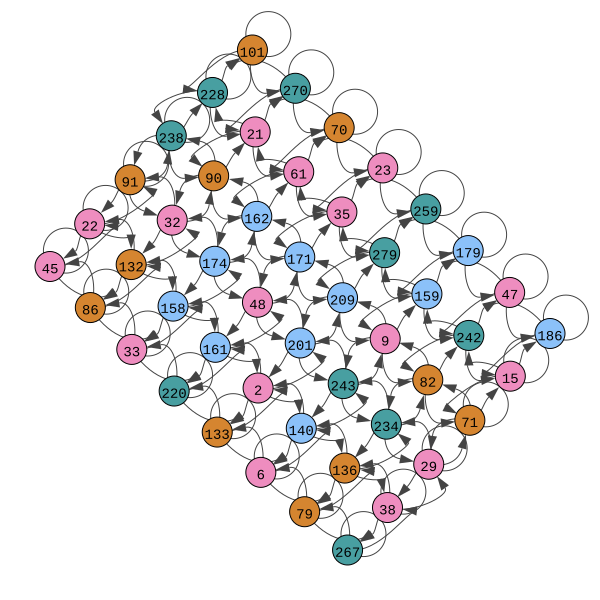

In [ ]:
graph = plot_graph(
    chmm_rand1, x_rand1, a_rand1, output_file="figures/rand_1_graph.pdf", cmap=cmap
)
graph

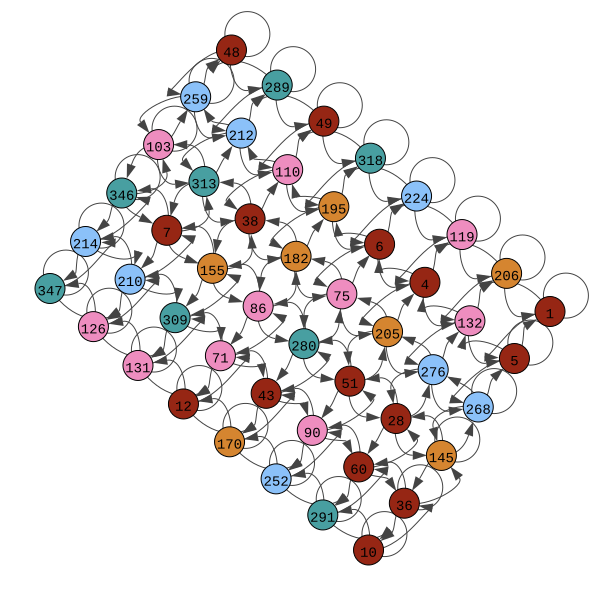

In [ ]:
graph = plot_graph(
    chmm_rand2, x_rand2, a_rand2, output_file="figures/rand_2_graph.pdf", cmap=cmap2, n_clones=n_clones2
)
graph

In [ ]:
obs_sequence_1, act_sequence_1 = snake_path(rand1, traverse_vertical=True, epochs=4)
obs_sequence_2, act_sequence_2 = snake_path(rand2, traverse_vertical=True, epochs=4)

mess_fwd_1 = get_mess_fwd(chmm_rand1, obs_sequence_1, pseudocount_E=0.1)
mess_fwd_2 = get_mess_fwd(chmm_rand2, obs_sequence_2, pseudocount_E=0.1)

chmm_rand1.anchors = np.array(mess_fwd_1)
chmm_rand1.mess_fwd = torch.Tensor(mess_fwd_1)
chmm_rand2.anchors = np.array(mess_fwd_2)
chmm_rand2.mess_fwd = torch.Tensor(mess_fwd_2)

chmm_rand1.obs_seq = obs_sequence_1
chmm_rand2.obs_seq = obs_sequence_2

In [ ]:
# Accuracy of reconstruction over time

recon_2 = reconstruct(mess_fwd_1, chmm_rand1.anchors, chmm_rand2.anchors)
recon_1 = reconstruct(mess_fwd_2, chmm_rand2.anchors, chmm_rand1.anchors)

similarities_1 = cosine_sim(mess_fwd_1, recon_1, dim=-1)
similarities_2 = cosine_sim(mess_fwd_2, recon_2, dim=-1)

print("Cosine sim 1->2: ", torch.mean(similarities_1))
print("Cosine sim 2->1: ", torch.mean(similarities_2))

Cosine sim 1->2:  tensor(0.9989)
Cosine sim 2->1:  tensor(0.9973)


In [ ]:
maxes_1 = np.argmax(mess_fwd_1,axis=1)
maxes_2 = np.argmax(mess_fwd_2,axis=1)

recon_maxes_1 = np.argmax(recon_1,axis=1)
recon_maxes_2 = np.argmax(recon_2,axis=1)

print("Accuracy recovering max belief 1->2: ", f"{sum(maxes_1 == recon_maxes_1)/len(maxes_1)*100}%")
print("Accuracy recovering max belief 2->1: ", f"{sum(maxes_2 == recon_maxes_2)/len(maxes_2)*100}%")

Accuracy recovering max belief 1->2:  99.33598937583001%
Accuracy recovering max belief 2->1:  99.46879150066401%


In [ ]:
# Add anchors
a_rand1, x_rand1, rc_rand1 = datagen_structured_obs_room(rand1, length=10000, seed=None)

a_rand2, x_rand2, rc_rand2 = datagen_structured_obs_room(
    rand2,
    start_r=0,
    start_c=0,
    no_left=[],
    no_right=[],
    no_up=[],
    no_down=[],
    length=None,
    seed=None,
    actions=a_rand1,
)

chmm_rand1, chmm_rand2 = add_anchors([chmm_rand1, chmm_rand2], [x_rand1, x_rand2], [a_rand1, a_rand2], num_anchors=5000)


a_rand12, x_rand12, rc_rand12 = datagen_structured_obs_room(rand1, length=10000, seed=None)

a_rand22, x_rand22, rc_rand22 = datagen_structured_obs_room(
    rand2,
    start_r=0,
    start_c=0,
    no_left=[],
    no_right=[],
    no_up=[],
    no_down=[],
    length=None,
    seed=None,
    actions=a_rand12,
)



In [ ]:
# Use actions to get mess_fwd
mess_fwd_12 = get_mess_fwd(chmm_rand1, x_rand12, a_rand12, pseudocount_E=0.1)
mess_fwd_22 = get_mess_fwd(chmm_rand2, x_rand22, a_rand22, pseudocount_E=0.1)

# Don't use actions to get mess_fwd
# mess_fwd_12 = get_mess_fwd(chmm_rand1, x_rand12, pseudocount_E=0.1)
# mess_fwd_22 = get_mess_fwd(chmm_rand2, x_rand22, pseudocount_E=0.1)

In [ ]:
# Accuracy of reconstruction over time (random path anchors)

recon_22 = reconstruct(mess_fwd_12, chmm_rand1.anchors, chmm_rand2.anchors)
recon_12 = reconstruct(mess_fwd_22, chmm_rand2.anchors, chmm_rand1.anchors)

similarities_12 = cosine_sim(mess_fwd_12, recon_12, dim=-1)
similarities_22 = cosine_sim(mess_fwd_22, recon_22, dim=-1)

print("Cosine sim 1->2: ", torch.mean(similarities_12))
print("Cosine sim 2->1: ", torch.mean(similarities_22))

Cosine sim 1->2:  tensor(0.9968)
Cosine sim 2->1:  tensor(0.9967)


In [ ]:
# Accuracy of reconstruction over time (random path anchors / no actions)

recon_22 = reconstruct(mess_fwd_12, chmm_rand1.anchors, chmm_rand2.anchors)
recon_12 = reconstruct(mess_fwd_22, chmm_rand2.anchors, chmm_rand1.anchors)

similarities_12 = cosine_sim(mess_fwd_12, recon_12, dim=-1)
similarities_22 = cosine_sim(mess_fwd_22, recon_22, dim=-1)

print("Cosine sim 1->2: ", torch.mean(similarities_12))
print("Cosine sim 2->1: ", torch.mean(similarities_22))

# with 5000 random anchors from a message generated w/o knowledge of actions
maxes_12 = np.argmax(mess_fwd_12,axis=1)
maxes_22 = np.argmax(mess_fwd_22,axis=1)

recon_maxes_12 = np.argmax(recon_12,axis=1)
recon_maxes_22 = np.argmax(recon_22,axis=1)

print("Accuracy recovering max belief 1->2: ", f"{sum(maxes_12 == recon_maxes_12)/len(maxes_12)*100}%")
print("Accuracy recovering max belief 2->1: ", f"{sum(maxes_22 == recon_maxes_22)/len(maxes_22)*100}%")

Cosine sim 1->2:  tensor(0.9984)
Cosine sim 2->1:  tensor(0.9983)
Accuracy recovering max belief 1->2:  99.83%
Accuracy recovering max belief 2->1:  99.83%


In [ ]:
# Accuracy of reconstruction over time (different # of obs levels)

recon_22 = reconstruct(mess_fwd_12, chmm_rand1.anchors, chmm_rand2.anchors)
recon_12 = reconstruct(mess_fwd_22, chmm_rand2.anchors, chmm_rand1.anchors)

similarities_12 = cosine_sim(mess_fwd_12, recon_12, dim=-1)
similarities_22 = cosine_sim(mess_fwd_22, recon_22, dim=-1)

print("Cosine sim 1->2: ", torch.mean(similarities_12))
print("Cosine sim 2->1: ", torch.mean(similarities_22))

# with 5000 random anchors from a message generated w/o knowledge of actions
maxes_12 = np.argmax(mess_fwd_12,axis=1)
maxes_22 = np.argmax(mess_fwd_22,axis=1)

recon_maxes_12 = np.argmax(recon_12,axis=1)
recon_maxes_22 = np.argmax(recon_22,axis=1)

print("Accuracy recovering max belief 1->2: ", f"{sum(maxes_12 == recon_maxes_12)/len(maxes_12)*100}%")
print("Accuracy recovering max belief 2->1: ", f"{sum(maxes_22 == recon_maxes_22)/len(maxes_22)*100}%")

Cosine sim 1->2:  tensor(0.9972)
Cosine sim 2->1:  tensor(0.9972)
Accuracy recovering max belief 1->2:  99.72%
Accuracy recovering max belief 2->1:  99.72%
